In [39]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import pandas as pd
import numpy as np
import sklearn
import re
import math
import joblib
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [40]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import re
import copy
from tqdm import tqdm
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report
)

from transformers import (
    AutoTokenizer,
    AutoModel,
    get_linear_schedule_with_warmup
)

import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

from transformers import BertTokenizer, BertForMaskedLM

from sklearn.metrics import (
    recall_score,
    precision_score
  )

from sklearn.metrics import multilabel_confusion_matrix

In [41]:
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import nltk

In [42]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

In [43]:
time_now = pd.Timestamp.now().strftime("%m-%d-%H-%M")
print(f"Time now: {time_now}")

Time now: 06-02-21-19


# Config

In [44]:
class Config:
    def __init__(self):
        super(Config, self).__init__()

        self.SEED = 42
        self.MODEL_PATH = 'allenai/scibert_scivocab_uncased'
        self.NUM_LABELS_TA = 14
        self.NUM_LABELS_TE = 185

        self.TOKENIZER = AutoTokenizer.from_pretrained(self.MODEL_PATH)
        self.MAX_LENGTH = 320
        self.BATCH_SIZE = 16

        self.DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.FULL_FINETUNING = True
        self.LR = 3e-5
        self.OPTIMIZER = 'AdamW'
        self.CRITERION = 'BCEWithLogitsLoss'
        self.N_VALIDATE_DUR_TRAIN = 3
        self.N_WARMUP = 0
        self.SAVE_BEST_ONLY = True
        self.EPOCHS = 50

In [45]:
TACTIC = ['TA0001', 'TA0002', 'TA0003', 'TA0004', 'TA0005', 'TA0006', 'TA0007', 'TA0008', 'TA0009', 'TA0010', 'TA0011', 'TA0040', 'TA0042', 'TA0043']
TECHNIQUE = ['T1001', 'T1003', 'T1005', 'T1006', 'T1007', 'T1008', 'T1010', 'T1011', 'T1012', 'T1014', 'T1016', 'T1018', 'T1020', 'T1021', 'T1025', 'T1027', 'T1029', 'T1030', 'T1033', 'T1036', 'T1037', 'T1039', 'T1040', 'T1041', 'T1046', 'T1047', 'T1048', 'T1049', 'T1052', 'T1053', 'T1055', 'T1056', 'T1057', 'T1059', 'T1068', 'T1069', 'T1071', 'T1072', 'T1074', 'T1078', 'T1080', 'T1082', 'T1083', 'T1087', 'T1090', 'T1091', 'T1092', 'T1095', 'T1098', 'T1102', 'T1104', 'T1105', 'T1106', 'T1110', 'T1111', 'T1112', 'T1113', 'T1114', 'T1115', 'T1119', 'T1120', 'T1123', 'T1124', 'T1125', 'T1127', 'T1129', 'T1132', 'T1133', 'T1134', 'T1135', 'T1136', 'T1137', 'T1140', 'T1176', 'T1185', 'T1187', 'T1189', 'T1190', 'T1195', 'T1197', 'T1199', 'T1200', 'T1201', 'T1202', 'T1203', 'T1204', 'T1205', 'T1207', 'T1210', 'T1211', 'T1212', 'T1213', 'T1216', 'T1218', 'T1220', 'T1221', 'T1222', 'T1480', 'T1482', 'T1485', 'T1486', 'T1489', 'T1490', 'T1491', 'T1495', 'T1496', 'T1497', 'T1498', 'T1499', 'T1505', 'T1518', 'T1525', 'T1526', 'T1528', 'T1529', 'T1531', 'T1534', 'T1535', 'T1537', 'T1538', 'T1539', 'T1542', 'T1543', 'T1546', 'T1547', 'T1548', 'T1550', 'T1552', 'T1553', 'T1555', 'T1556', 'T1557', 'T1558', 'T1559', 'T1560', 'T1561', 'T1562', 'T1563', 'T1564', 'T1565', 'T1566', 'T1567', 'T1568', 'T1569', 'T1570', 'T1571', 'T1572', 'T1573', 'T1574', 'T1578', 'T1580', 'T1583', 'T1584', 'T1585', 'T1586', 'T1587', 'T1588', 'T1589', 'T1590', 'T1591', 'T1592', 'T1593', 'T1594', 'T1595', 'T1596', 'T1597', 'T1598', 'T1599', 'T1600', 'T1601', 'T1602', 'T1606', 'T1608', 'T1609', 'T1610', 'T1611', 'T1612', 'T1613', 'T1614', 'T1615', 'T1619', 'T1620', 'T1621', 'T1622', 'T1647']
TACTICS_TECHNIQUES_RELATIONSHIP_DF = {
"TA0001":pd.Series(['T1078', 'T1091', 'T1133', 'T1189', 'T1190', 'T1195', 'T1199', 'T1200', 'T1566', 'T1659', 'T1669']),
"TA0002":pd.Series(['T1047', 'T1053', 'T1059', 'T1072', 'T1106', 'T1129', 'T1203', 'T1204', 'T1559', 'T1569', 'T1609', 'T1610', 'T1648', 'T1651', 'T1674', 'T1675']),
"TA0003":pd.Series(['T1037', 'T1053', 'T1078', 'T1098', 'T1112', 'T1133', 'T1136', 'T1137', 'T1176', 'T1197', 'T1205', 'T1505', 'T1525', 'T1542', 'T1543', 'T1546', 'T1547', 'T1554', 'T1556', 'T1574', 'T1653', 'T1668', 'T1671']),
"TA0004":pd.Series(['T1037', 'T1053', 'T1055', 'T1068', 'T1078', 'T1098', 'T1134', 'T1484', 'T1543', 'T1546', 'T1547', 'T1548', 'T1574', 'T1611']),
"TA0005":pd.Series(['T1006', 'T1014', 'T1027', 'T1036', 'T1055', 'T1070', 'T1078', 'T1112', 'T1127', 'T1134', 'T1140', 'T1197', 'T1202', 'T1205', 'T1207', 'T1211', 'T1216', 'T1218', 'T1220', 'T1221', 'T1222', 'T1480', 'T1484', 'T1497', 'T1535', 'T1542', 'T1548', 'T1550', 'T1553', 'T1556', 'T1562', 'T1564', 'T1574', 'T1578', 'T1599', 'T1600', 'T1601', 'T1610', 'T1612', 'T1620', 'T1622', 'T1647', 'T1656', 'T1666', 'T1672']),
"TA0006":pd.Series(['T1003', 'T1040', 'T1056', 'T1110', 'T1111', 'T1187', 'T1212', 'T1528', 'T1539', 'T1552', 'T1555', 'T1556', 'T1557', 'T1558', 'T1606', 'T1621', 'T1649']),
"TA0007":pd.Series(['T1007', 'T1010', 'T1012', 'T1016', 'T1018', 'T1033', 'T1040', 'T1046', 'T1049', 'T1057', 'T1069', 'T1082', 'T1083', 'T1087', 'T1120', 'T1124', 'T1135', 'T1201', 'T1217', 'T1482', 'T1497', 'T1518', 'T1526', 'T1538', 'T1580', 'T1613', 'T1614', 'T1615', 'T1619', 'T1622', 'T1652', 'T1654', 'T1673']),
"TA0008":pd.Series(['T1021', 'T1072', 'T1080', 'T1091', 'T1210', 'T1534', 'T1550', 'T1563', 'T1570']),
"TA0009":pd.Series(['T1005', 'T1025', 'T1039', 'T1056', 'T1074', 'T1113', 'T1114', 'T1115', 'T1119', 'T1123', 'T1125', 'T1185', 'T1213', 'T1530', 'T1557', 'T1560', 'T1602']),
"TA0010":pd.Series(['T1011', 'T1020', 'T1029', 'T1030', 'T1041', 'T1048', 'T1052', 'T1537', 'T1567']),
"TA0011":pd.Series(['T1001', 'T1008', 'T1071', 'T1090', 'T1092', 'T1095', 'T1102', 'T1104', 'T1105', 'T1132', 'T1205', 'T1219', 'T1568', 'T1571', 'T1572', 'T1573', 'T1659', 'T1665']),
"TA0040":pd.Series(['T1485', 'T1486', 'T1489', 'T1490', 'T1491', 'T1495', 'T1496', 'T1498', 'T1499', 'T1529', 'T1531', 'T1561', 'T1565', 'T1657', 'T1667']),                
"TA0042":pd.Series(['T1583', 'T1584', 'T1585', 'T1586', 'T1587', 'T1588', 'T1608', 'T1650']),
"TA0043":pd.Series(['T1589', 'T1590', 'T1591', 'T1592', 'T1593', 'T1594', 'T1595', 'T1596', 'T1597', 'T1598'])
}

In [46]:
df = pd.read_csv('merged_all_columns.csv', encoding='utf-8')
# df_attack['tactic_label'] = df_attack.apply(lambda x: list(x[TACTIC]), axis=1)
# df_attack['technique_label'] = df_attack.apply(lambda x: list(x[TECHNIQUE]), axis=1)

df_tactic_labels = df[TACTIC]
df_technique_labels = df[TECHNIQUE]

In [47]:
print(df_tactic_labels)

      TA0001  TA0002  TA0003  TA0004  TA0005  TA0006  TA0007  TA0008  TA0009  \
0          1       1       0       0       0       0       0       0       0   
1          1       1       0       0       0       0       0       0       0   
2          0       1       0       0       0       1       0       0       0   
3          1       1       0       0       0       0       0       0       0   
4          1       0       0       1       1       0       0       0       0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
1513       0       1       1       0       0       0       0       0       0   
1514       0       0       0       0       0       0       0       0       0   
1515       0       0       0       1       0       0       0       0       0   
1516       0       1       0       0       0       0       0       0       1   
1517       0       0       0       0       0       0       0       0       0   

      TA0010  TA0011  TA0040  TA0042  T

In [48]:
print(df_technique_labels)

      T1001  T1003  T1005  T1006  T1007  T1008  T1010  T1011  T1012  T1014  \
0         0      0      0      0      0      0      0      0      0      0   
1         0      0      0      0      0      0      0      0      0      0   
2         0      1      0      0      0      0      0      0      0      0   
3         0      0      0      0      0      0      0      0      0      0   
4         0      0      0      0      0      0      0      0      0      0   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
1513      0      0      0      0      0      0      0      0      0      0   
1514      0      0      0      0      0      0      0      0      0      0   
1515      0      0      0      0      0      0      0      0      0      0   
1516      0      0      1      0      0      0      0      0      0      0   
1517      0      0      0      0      0      0      0      0      0      0   

      ...  T1611  T1612  T1613  T1614  T1615  T1619  T1620  T16

In [49]:
df['tactic_label'] = df.apply(lambda x: list(x[TACTIC]), axis=1)
df['technique_label'] = df.apply(lambda x: list(x[TECHNIQUE]), axis=1)


# Data processing

In [50]:
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import nltk

In [51]:
import nltk

resources = [
    "punkt",
    "stopwords",
    "wordnet",
    "omw-1.4",
    "averaged_perceptron_tagger",
    "averaged_perceptron_tagger_eng"
]

for res in resources:
    try:
        nltk.data.find(res)
        print(f"{res} ✅ 已安裝")
    except LookupError:
        print(f"{res} ⛔ 未安裝，開始下載...")
        nltk.download(res)


punkt ⛔ 未安裝，開始下載...
stopwords ⛔ 未安裝，開始下載...
wordnet ⛔ 未安裝，開始下載...
omw-1.4 ⛔ 未安裝，開始下載...
averaged_perceptron_tagger ⛔ 未安裝，開始下載...
averaged_perceptron_tagger_eng ⛔ 未安裝，開始下載...


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_t

In [52]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return 'n'

def ioc_sub(text):
    def reg_handler(obj):
        s = obj.group(1)
        s = ' '.join(s.split('\\'))
        return s

    def file_handler(obj):
        s = obj.group(2)
        s = s.split('\\')[-1]
        return s
    
    text = re.sub(r'(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.|\[\.\])){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\/([0-2][0-9]|3[0-2]|[0-9]))?', 'IPv4', text)
    text = re.sub(r'\b(\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3})\b', 'IP', text)
    text = re.sub(r'\b(CVE\-[0-9]{4}\-[0-9]{4,6})\b', 'CVE', text)
    text = re.sub(r'CVE-[0-9]{4}-[0-9]{4,6}', 'vulnerability', text)
    text = re.sub(r'\b([a-z][_a-z0-9-.]+@[a-z0-9-]+\.[a-z]+)\b', 'email', text)
    text = re.sub(r'\b((HKLM|HKCU|HKCR|HKU|HKCC)\\[\\A-Za-z0-9-_]+)\b', reg_handler, text)
    text = re.sub(r'\b([a-zA-Z]{1}:\\([0-9a-zA-Z_\.\-\/\\]+))\b', file_handler, text)
    text = re.sub(r'\b([a-f0-9]{32}|[A-F0-9]{32})\b', 'MD5', text)
    text = re.sub(r'\b([a-f0-9]{40}|[A-F0-9]{40})\b', 'SHA1', text)
    text = re.sub(r'\b([a-f0-9]{64}|[A-F0-9]{64})\b', 'SHA256', text)
    text = re.sub(r'\d+:[A-Za-z0-9/+]+:[A-Za-z0-9/+]+', 'ssdeep', text)
    text = re.sub(r'\b[a-fA-F\d]{32}\b|\b[a-fA-F\d]{40}\b|\b[a-fA-F\d]{64}\b', 'hash', text)
    text = re.sub(r'h[tx][tx]ps?:[\\\/][\\\/](?:[0-9a-zA-Z_\.\-\/\\]|\[\.\])+', 'URL', text)
    text = re.sub(r'((?:[0-9a-zA-Z_\-]+\.)+(?:(?!exe|dll)[a-z]{2,4}))', 'domain', text)
    text = re.sub(r'[a-fA-F0-9]{16}', '', text)
    text = re.sub(r'[0-9]{8}', '', text)
    text = re.sub(r'x[A-Fa-f0-9]{2}', '', text)
    
    return text

def rmstopword_and_lemmatize(text):
    token = [word for word in word_tokenize(text.lower()) if word not in stopwords.words('english')]
    # tag = pos_tag(token)
    tag = nltk.pos_tag(token, lang='eng')
    lemmatizer = WordNetLemmatizer()
    text = ' '.join(list(map(lambda x: lemmatizer.lemmatize(x[0], pos=get_wordnet_pos(x[1])), tag)))
    
    return text

def preprocess(text):
    text = str(text)
    #text = text.lower()
    text = re.sub(r'etc\.', '', text)
    text = re.sub(r'et al\.', '', text)
    text = re.sub(r'e\.g\.', '', text)
    text = re.sub(r'i\.e\.', '', text)
    #text = re.sub(r'\[.\]', '.', text)
    text = re.sub(r'\[\d+\]', '', text)
    
    text = ioc_sub(text)
    
    text = re.sub(r'[^A-Za-z0-9_\[\]]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    
    text = rmstopword_and_lemmatize(text)
    
    text = re.sub(r'[\[\]]', ' ', text)
    text = re.sub(r' [a-z0-9] ', '', text)
    
    return text


In [53]:
df['text_clean'] = df['Text'].map(lambda t: preprocess(t))

In [54]:
print(df['text_clean'][0])

waspthemes visual cs style editor aka yellow pencil visual theme customizer plugin2wordpress allows yp_option_update csrf demonstrate use yp_remote_get obtain admin access


In [55]:
print(df.iloc[0])

ID                                                    CVE_2019_11886
Text               The WaspThemes Visual CSS Style Editor (aka ye...
TA0001                                                             1
TA0002                                                             1
TA0003                                                             0
                                         ...                        
T1622                                                              0
T1647                                                              0
tactic_label              [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
technique_label    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
text_clean         waspthemes visual cs style editor aka yellow p...
Name: 0, Length: 204, dtype: object


# Dataset & Dataloader

In [56]:
def get_texts(df):
    texts = df['text']
    texts = texts.values.tolist()
    return texts

def get_labels(df):
    labels = df['labels'].values
    return labels

def get_ids(df):
    ids = df['ID'].values.tolist()

In [57]:
from torch.utils.data import Dataset, DataLoader
class TransformerDataset_ta(Dataset):
    def __init__(self, df, indices, set_type=None):
        super(TransformerDataset_ta, self).__init__()

        df = df.iloc[indices]
        self.texts = get_texts(df)
        self.set_type = set_type
        if self.set_type != 'test':
            self.labels = get_labels(df)

        self.tokenizer = Config().TOKENIZER
        self.max_length = Config().MAX_LENGTH

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        tokenized = self.tokenizer.encode_plus(
            self.texts[index],
            max_length=self.max_length,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )

        input_ids = tokenized['input_ids'].squeeze()
        attention_mask = tokenized['attention_mask'].squeeze()

        if self.set_type != 'test':
            return {
                'input_ids': input_ids.long(),
                'attention_mask': attention_mask.long(),
                'labels': torch.Tensor(self.labels[index]).float(),
            }

        return {
            'input_ids': input_ids.long(),
            'attention_mask': attention_mask.long(),
        }

In [58]:

class TransformerDataset_te(Dataset):
    def __init__(self, df, indices, set_type=None):
        super(TransformerDataset_te, self).__init__()

        df = df.iloc[indices]
        self.texts = get_texts(df)
        self.set_type = set_type
        if self.set_type != 'test':
            self.labels = get_labels(df)

        self.tokenizer = Config().TOKENIZER
        self.max_length = Config().MAX_LENGTH

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        tokenized = self.tokenizer.encode_plus(
            self.texts[index],
            max_length=self.max_length,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )

        input_ids = tokenized['input_ids'].squeeze()
        attention_mask = tokenized['attention_mask'].squeeze()

        if self.set_type != 'test':
            return {
                'input_ids': input_ids.long(),
                'attention_mask': attention_mask.long(),
                'labels': torch.Tensor(self.labels[index]).float(),
            }

        return {
            'input_ids': input_ids.long(),
            'attention_mask': attention_mask.long(),
        }

In [59]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=2222)
validation, test = train_test_split(test, test_size=0.5, random_state=2222)

In [60]:
df_ta_train = train[['text_clean', 'tactic_label']]
df_ta_val = validation[['text_clean', 'tactic_label']]
df_ta_test = test[['text_clean', 'tactic_label']]
df_ta_train = df_ta_train.rename(columns={'text_clean':'text', 'tactic_label':'labels'})
df_ta_val = df_ta_val.rename(columns={'text_clean':'text', 'tactic_label':'labels'})
df_ta_test = df_ta_test.rename(columns={'text_clean':'text', 'tactic_label':'labels'})


In [61]:
# df_te_train = df.iloc[train.index][['text_clean', 'technique_label']]
# df_te_val = df.iloc[validation.index][['text_clean', 'technique_label']]
# df_te_test = df.iloc[test.index][['text_clean', 'technique_label']]
# df_te_train = df_te_train.rename(columns={'text_clean':'text', 'technique_label':'labels'})
# df_te_val = df_te_val.rename(columns={'text_clean':'text', 'technique_label':'labels'})
# df_te_test = df_te_test.rename(columns={'text_clean':'text', 'technique_label':'labels'})

In [62]:
train_data_ta = TransformerDataset_ta(df_ta_train, range(len(df_ta_train)))
val_data_ta = TransformerDataset_ta(df_ta_val, range(len(df_ta_val)))
test_data_ta = TransformerDataset_ta(df_ta_test, range(len(df_ta_test)))

In [63]:
# train_data_te = TransformerDataset_te(df_ta_train, range(len(df_te_train)))
# val_data_te = TransformerDataset_te(df_ta_val, range(len(df_te_val)))
# test_data_te = TransformerDataset_te(df_ta_test, range(len(df_te_test)))

In [64]:
train_dataloader_ta = DataLoader(train_data_ta, batch_size=Config().BATCH_SIZE)
val_dataloader_ta = DataLoader(val_data_ta, batch_size=Config().BATCH_SIZE)
test_dataloader_ta = DataLoader(test_data_ta, batch_size=Config().BATCH_SIZE)

In [65]:
# train_dataloader_te = DataLoader(train_data_te, batch_size=Config().BATCH_SIZE)
# val_dataloader_te = DataLoader(val_data_te, batch_size=Config().BATCH_SIZE)
# test_dataloader_te = DataLoader(test_data_te, batch_size=Config().BATCH_SIZE)

In [66]:
train_dataloader = train_dataloader_ta
val_dataloader = val_dataloader_ta
test_dataloader = test_dataloader_ta

In [67]:
b = next(iter(train_dataloader_ta))
for k, v in b.items():
    print(f'{k} shape: {v.shape}')

input_ids shape: torch.Size([16, 320])
attention_mask shape: torch.Size([16, 320])
labels shape: torch.Size([16, 14])


# Model

In [68]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.transformer_model = AutoModel.from_pretrained(
                Config().MODEL_PATH
        )
        self.dropout = nn.Dropout(0.3)

        self.output = nn.Linear(768, Config().NUM_LABELS_TA)

    def forward(
        self,
        input_ids,
        attention_mask=None,
        token_type_ids=None
        ):

        _, o2 = self.transformer_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=False
        )

        x = self.dropout(o2)
        out = self.output(x)

        return out

# Train and test

In [69]:
BEST_F1 = 0
BEST_TRUE = []
BEST_PREDICTED = []

In [70]:
metrics_log = [] 

In [71]:
def val(model, val_dataloader, criterion, is_final_test=False):
    global BEST_F1, BEST_TRUE, BEST_PREDICTED, device

    val_loss = 0
    true, pred = [], []

    model.eval()

    results = {}

    for step, batch in enumerate(val_dataloader):
        b_input_ids = batch['input_ids'].to(device)
        b_attention_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        with torch.no_grad():
            logits = model(input_ids=b_input_ids, attention_mask=b_attention_mask)

            loss = criterion(logits, b_labels)
            val_loss += loss.item()

            logits = torch.sigmoid(logits)
            logits = np.round(logits.cpu().numpy())
            labels = b_labels.cpu().numpy()

            pred.extend(logits)
            true.extend(labels)

    # avg_val_loss = val_loss / len(val_dataloader)
    # print('Val loss:', avg_val_loss)
    # print('Val accuracy:', accuracy_score(true, pred))

    # print('Val precision:', precision_score(true, pred, average='weighted'))
    # print('Val recall:', recall_score(true, pred, average='weighted'))

    # val_micro_f1_score = f1_score(true, pred, average='micro')
    # print('Val micro f1 score:', val_micro_f1_score)

    # val_macro_f1_score = f1_score(true, pred, average='macro')
    # print('Val macro f1 score:', val_macro_f1_score)

    val_weighted_f1_score = f1_score(true, pred, average='weighted')
    # print('Val weighted f1 score:', val_weighted_f1_score)

    results.update({
        "f1_sampled": f1_score(true, pred, average='samples', zero_division=0),
        "f1_micro": f1_score(true, pred, average='micro', zero_division=0),
        "f1_macro": f1_score(true, pred, average='macro', zero_division=0),
        "f_05_sample": fbeta_score(true, pred, average='samples', beta=0.5, zero_division=0),
        "f_05_micro": fbeta_score(true, pred, average='micro', beta=0.5, zero_division=0),
        "f_05_macro": fbeta_score(true, pred, average='macro', beta=0.5, zero_division=0),
        "precision_sampled": precision_score(true, pred, average='samples', zero_division=0),
        "precision_micro": precision_score(true, pred, average='micro', zero_division=0),
        "precision_macro": precision_score(true, pred, average='macro', zero_division=0),
        "recall_sampled": recall_score(true, pred, average='samples', zero_division=0),
        "recall_micro": recall_score(true, pred, average='micro', zero_division=0),
        "recall_macro": recall_score(true, pred, average='macro', zero_division=0),
        "accuracy": accuracy_score(true, pred),
        })

    labels_float = labels.astype(float)
    results.update({
        "coverage_error": coverage_error(labels_float, logits),
        "label_ranking_loss": label_ranking_loss(labels_float, logits),
        "lrap": label_ranking_average_precision_score(labels_float, logits),
    })

    metrics_log.append(results.copy())

    print(results)


    if (is_final_test is True):
      BEST_F1 = val_weighted_f1_score
      BEST_TRUE = true
      BEST_PREDICTED = pred
    elif (val_weighted_f1_score > BEST_F1):
      BEST_F1 = val_weighted_f1_score
      BEST_TRUE = true
      BEST_PREDICTED = pred

    return val_weighted_f1_score



In [72]:
def train(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, epoch):
    global device
    nv = Config().N_VALIDATE_DUR_TRAIN
    temp = len(train_dataloader) // nv
    temp = temp - (temp % 100)
    validate_at_steps = [temp * x for x in range(1, nv + 1)]

    train_loss = 0
    train_losses = []

    for step, batch in enumerate(tqdm(train_dataloader,
                                      desc='Epoch ' + str(epoch))):
        model.train()

        b_input_ids = batch['input_ids'].to(device)
        b_attention_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        optimizer.zero_grad()

        logits = model(input_ids=b_input_ids, attention_mask=b_attention_mask)

        loss = criterion(logits, b_labels)
        train_loss += loss.item()

        loss.backward()

        optimizer.step()

        scheduler.step()

        if step in validate_at_steps:
            print(f'-- Step: {step}')
            _ = val(model, val_dataloader, criterion)


    avg_train_loss = train_loss / len(train_dataloader)
    print('Training loss:', avg_train_loss)

In [73]:
def run():
    global train_data, val_data, test_data, train_dataloader, val_dataloader, test_dataloader, model
    torch.manual_seed(Config().SEED)

    criterion = nn.BCEWithLogitsLoss()

    if Config().FULL_FINETUNING:
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {
                "params": [
                    p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.001,
            },
            {
                "params": [
                    p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.0,
            },
        ]
        optimizer = optim.AdamW(optimizer_parameters, lr=Config().LR)

    num_training_steps = len(train_dataloader) * Config().EPOCHS
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
    )

    max_val_weighted_f1_score = float('-inf')
    for epoch in range(Config().EPOCHS):
        train(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, epoch)
        val_weighted_f1_score = val(model, val_dataloader, criterion)

        if Config().SAVE_BEST_ONLY:
            if val_weighted_f1_score > max_val_weighted_f1_score:
                best_model = copy.deepcopy(model)

                model_name = 'scibert_best_model'
                torch.save(best_model.state_dict(), model_name + '.pt')

                print(f'--- Best Model. Val: {max_val_weighted_f1_score} -> {val_weighted_f1_score}')
                max_val_weighted_f1_score = val_weighted_f1_score

    return best_model, max_val_weighted_f1_score

# Tactic_multi model

In [74]:
from sklearn.metrics import coverage_error, label_ranking_average_precision_score, label_ranking_loss
from sklearn.metrics import hamming_loss, precision_score, recall_score, f1_score, fbeta_score
from sklearn.metrics import accuracy_score

In [75]:
project_dir = './'
config = Config()
device = Config().DEVICE
model = Model()
model.to(device)

Model(
  (transformer_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [76]:
best_model_ta, best_val_weighted_f1_score_ta = run()

Epoch 0:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 0:   1%|▏         | 1/76 [00:01<01:54,  1.53s/it]

{'f1_sampled': 0.2866593567251462, 'f1_micro': 0.29985855728429983, 'f1_macro': 0.09383927358261158, 'f_05_sample': 0.25326370721031183, 'f_05_micro': 0.25286259541984735, 'f_05_macro': 0.07084824935322967, 'precision_sampled': 0.23848684210526316, 'precision_micro': 0.22894168466522677, 'precision_macro': 0.061003710219049656, 'recall_sampled': 0.4182017543859649, 'recall_micro': 0.4344262295081967, 'recall_macro': 0.2780906969022227, 'accuracy': 0.019736842105263157, 'coverage_error': np.float64(12.625), 'label_ranking_loss': np.float64(0.7309731934731936), 'lrap': np.float64(0.22371031746031747)}


Epoch 0: 100%|██████████| 76/76 [00:08<00:00,  8.69it/s]


Training loss: 0.33535270824244146
{'f1_sampled': 0.0043859649122807015, 'f1_micro': 0.00816326530612245, 'f1_macro': 0.0026455026455026454, 'f_05_sample': 0.005482456140350878, 'f_05_micro': 0.020161290322580645, 'f_05_macro': 0.006265664160401002, 'precision_sampled': 0.006578947368421052, 'precision_micro': 1.0, 'precision_macro': 0.07142857142857142, 'recall_sampled': 0.003289473684210526, 'recall_micro': 0.004098360655737705, 'recall_macro': 0.001347708894878706, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(14.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.1607142857142857)}
--- Best Model. Val: -inf -> 0.008044930176077717


Epoch 1:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 1:   4%|▍         | 3/76 [00:01<00:26,  2.75it/s]

{'f1_sampled': 0.046052631578947366, 'f1_micro': 0.06324110671936758, 'f1_macro': 0.018433179723502304, 'f_05_sample': 0.049342105263157895, 'f_05_micro': 0.14285714285714285, 'f_05_macro': 0.03210272873194221, 'precision_sampled': 0.05263157894736842, 'precision_micro': 0.8888888888888888, 'precision_macro': 0.06349206349206349, 'recall_sampled': 0.04276315789473684, 'recall_micro': 0.03278688524590164, 'recall_macro': 0.010781671159029648, 'accuracy': 0.09210526315789473, 'coverage_error': np.float64(14.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.1607142857142857)}


Epoch 1: 100%|██████████| 76/76 [00:08<00:00,  9.12it/s]


Training loss: 0.28163197499356774
{'f1_sampled': 0.2777568922305764, 'f1_micro': 0.3780821917808219, 'f1_macro': 0.11280347559417327, 'f_05_sample': 0.2812752853871275, 'f_05_micro': 0.4739010989010989, 'f_05_macro': 0.12487753722178528, 'precision_sampled': 0.29605263157894735, 'precision_micro': 0.5702479338842975, 'precision_macro': 0.14018218623481782, 'recall_sampled': 0.3055921052631579, 'recall_micro': 0.2827868852459016, 'recall_macro': 0.10688649947263565, 'accuracy': 0.14473684210526316, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.6033653846153846), 'lrap': np.float64(0.45982142857142855)}
--- Best Model. Val: 0.008044930176077717 -> 0.2853622295864004


Epoch 2:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 2:   4%|▍         | 3/76 [00:00<00:18,  3.86it/s]

{'f1_sampled': 0.2652568922305764, 'f1_micro': 0.3657142857142857, 'f1_macro': 0.11178456890002376, 'f_05_sample': 0.2717332010095168, 'f_05_micro': 0.47904191616766467, 'f_05_macro': 0.1265241987245142, 'precision_sampled': 0.28618421052631576, 'precision_micro': 0.6037735849056604, 'precision_macro': 0.1431663574520717, 'recall_sampled': 0.2820175438596491, 'recall_micro': 0.26229508196721313, 'recall_macro': 0.10041713055197468, 'accuracy': 0.17105263157894737, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.6658653846153846), 'lrap': np.float64(0.40624999999999994)}


Epoch 2: 100%|██████████| 76/76 [00:07<00:00,  9.56it/s]


Training loss: 0.2511332174272914
{'f1_sampled': 0.3474937343358396, 'f1_micro': 0.43256997455470736, 'f1_macro': 0.13276370789279568, 'f_05_sample': 0.3557643014879857, 'f_05_micro': 0.5059523809523809, 'f_05_macro': 0.13460142216256119, 'precision_sampled': 0.3717105263157895, 'precision_micro': 0.5704697986577181, 'precision_macro': 0.13729862867793902, 'recall_sampled': 0.3620614035087719, 'recall_micro': 0.3483606557377049, 'recall_macro': 0.13675583030587132, 'accuracy': 0.21710526315789475, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.6033653846153846), 'lrap': np.float64(0.45982142857142855)}
--- Best Model. Val: 0.2853622295864004 -> 0.32704847493016564


Epoch 3:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 3:   4%|▍         | 3/76 [00:00<00:16,  4.37it/s]

{'f1_sampled': 0.3615288220551378, 'f1_micro': 0.43842364532019706, 'f1_macro': 0.13259676284306826, 'f_05_sample': 0.36594600574863734, 'f_05_micro': 0.49887892376681614, 'f_05_macro': 0.13217221412374475, 'precision_sampled': 0.37938596491228066, 'precision_micro': 0.5493827160493827, 'precision_macro': 0.13346683908665305, 'recall_sampled': 0.3850877192982456, 'recall_micro': 0.36475409836065575, 'recall_macro': 0.14235175202156333, 'accuracy': 0.21710526315789475, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6129807692307692), 'lrap': np.float64(0.39732142857142855)}


Epoch 3: 100%|██████████| 76/76 [00:07<00:00,  9.71it/s]


Training loss: 0.2283568501864609
{'f1_sampled': 0.32687969924812027, 'f1_micro': 0.4034090909090909, 'f1_macro': 0.15808354973909047, 'f_05_sample': 0.348514515455305, 'f_05_micro': 0.5251479289940828, 'f_05_macro': 0.18736680326561908, 'precision_sampled': 0.3782894736842105, 'precision_micro': 0.6574074074074074, 'precision_macro': 0.22277466542172425, 'recall_sampled': 0.3196271929824562, 'recall_micro': 0.29098360655737704, 'recall_macro': 0.13113770355388343, 'accuracy': 0.21710526315789475, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.8221153846153846), 'lrap': np.float64(0.2678571428571428)}
--- Best Model. Val: 0.32704847493016564 -> 0.340810249451279


Epoch 4:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 4:   4%|▍         | 3/76 [00:00<00:17,  4.12it/s]

{'f1_sampled': 0.3385964912280701, 'f1_micro': 0.41304347826086957, 'f1_macro': 0.1545654351070314, 'f_05_sample': 0.35596804511278196, 'f_05_micro': 0.5135135135135135, 'f_05_macro': 0.18043553912660176, 'precision_sampled': 0.3815789473684211, 'precision_micro': 0.6129032258064516, 'precision_macro': 0.21539615846338536, 'recall_sampled': 0.3410087719298246, 'recall_micro': 0.3114754098360656, 'recall_macro': 0.13413485025232216, 'accuracy': 0.20394736842105263, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7908653846153846), 'lrap': np.float64(0.2901785714285714)}


Epoch 4: 100%|██████████| 76/76 [00:07<00:00,  9.62it/s]


Training loss: 0.20556267880295453
{'f1_sampled': 0.3966165413533834, 'f1_micro': 0.4631043256997455, 'f1_macro': 0.20105341097845617, 'f_05_sample': 0.4324075047759259, 'f_05_micro': 0.5416666666666666, 'f_05_macro': 0.22446936907364345, 'precision_sampled': 0.4780701754385964, 'precision_micro': 0.610738255033557, 'precision_macro': 0.2518800195544382, 'recall_sampled': 0.37741228070175437, 'recall_micro': 0.3729508196721312, 'recall_macro': 0.18165106515058477, 'accuracy': 0.21710526315789475, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.5981570512820513), 'lrap': np.float64(0.4389880952380952)}
--- Best Model. Val: 0.340810249451279 -> 0.41521833219649823


Epoch 5:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 5:   4%|▍         | 3/76 [00:00<00:17,  4.23it/s]

{'f1_sampled': 0.4160714285714286, 'f1_micro': 0.4836272040302267, 'f1_macro': 0.21155638288765224, 'f_05_sample': 0.44895277419948476, 'f_05_micro': 0.5607476635514018, 'f_05_macro': 0.23298922087660628, 'precision_sampled': 0.4934210526315789, 'precision_micro': 0.6274509803921569, 'precision_macro': 0.25603192528658364, 'recall_sampled': 0.40372807017543855, 'recall_micro': 0.39344262295081966, 'recall_macro': 0.19003775451511826, 'accuracy': 0.23684210526315788, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.57069493006993), 'lrap': np.float64(0.4404761904761904)}


Epoch 5: 100%|██████████| 76/76 [00:07<00:00,  9.67it/s]


Training loss: 0.17963985863484835
{'f1_sampled': 0.40983709273182956, 'f1_micro': 0.45662100456621, 'f1_macro': 0.20115270487370443, 'f_05_sample': 0.4325996554614976, 'f_05_micro': 0.49019607843137253, 'f_05_macro': 0.21106912309098808, 'precision_sampled': 0.46491228070175433, 'precision_micro': 0.5154639175257731, 'precision_macro': 0.22325998681930884, 'recall_sampled': 0.411951754385965, 'recall_micro': 0.4098360655737705, 'recall_macro': 0.20045025078431133, 'accuracy': 0.20394736842105263, 'coverage_error': np.float64(9.375), 'label_ranking_loss': np.float64(0.49777826340326337), 'lrap': np.float64(0.5044642857142858)}


Epoch 6:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 6:   4%|▍         | 3/76 [00:00<00:14,  4.97it/s]

{'f1_sampled': 0.41356516290726814, 'f1_micro': 0.4646924829157175, 'f1_macro': 0.2067593210011594, 'f_05_sample': 0.43355255855255853, 'f_05_micro': 0.498046875, 'f_05_macro': 0.21750574417992471, 'precision_sampled': 0.46271929824561403, 'precision_micro': 0.5230769230769231, 'precision_macro': 0.22950720375969547, 'recall_sampled': 0.42017543859649126, 'recall_micro': 0.4180327868852459, 'recall_macro': 0.2043781337815882, 'accuracy': 0.20394736842105263, 'coverage_error': np.float64(9.375), 'label_ranking_loss': np.float64(0.49777826340326337), 'lrap': np.float64(0.5044642857142858)}


Epoch 6: 100%|██████████| 76/76 [00:07<00:00,  9.77it/s]


Training loss: 0.15822342891050012
{'f1_sampled': 0.4381578947368421, 'f1_micro': 0.4830917874396135, 'f1_macro': 0.21777111777111777, 'f_05_sample': 0.469348451256346, 'f_05_micro': 0.5411255411255411, 'f_05_macro': 0.23425481575612087, 'precision_sampled': 0.5098684210526315, 'precision_micro': 0.5882352941176471, 'precision_macro': 0.24789351837532952, 'recall_sampled': 0.425438596491228, 'recall_micro': 0.4098360655737705, 'recall_macro': 0.19744698830471813, 'accuracy': 0.2631578947368421, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.5929487179487178), 'lrap': np.float64(0.4702380952380952)}
--- Best Model. Val: 0.41521833219649823 -> 0.4455628160546192


Epoch 7:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 7:   4%|▍         | 3/76 [00:00<00:17,  4.18it/s]

{'f1_sampled': 0.44620927318295744, 'f1_micro': 0.49295774647887325, 'f1_macro': 0.2213556255026215, 'f_05_sample': 0.47770422194764295, 'f_05_micro': 0.5401234567901234, 'f_05_macro': 0.2326710946967923, 'precision_sampled': 0.5175438596491228, 'precision_micro': 0.5769230769230769, 'precision_macro': 0.24149666123350336, 'recall_sampled': 0.431140350877193, 'recall_micro': 0.430327868852459, 'recall_macro': 0.20654050541793662, 'accuracy': 0.26973684210526316, 'coverage_error': np.float64(7.875), 'label_ranking_loss': np.float64(0.4679487179487179), 'lrap': np.float64(0.5773809523809524)}


Epoch 7: 100%|██████████| 76/76 [00:07<00:00,  9.58it/s]


Training loss: 0.13715424045528235
{'f1_sampled': 0.400125313283208, 'f1_micro': 0.45595854922279794, 'f1_macro': 0.2027480246757088, 'f_05_sample': 0.43599602152233724, 'f_05_micro': 0.541871921182266, 'f_05_macro': 0.23197076603834418, 'precision_sampled': 0.47916666666666674, 'precision_micro': 0.6197183098591549, 'precision_macro': 0.26092740126353575, 'recall_sampled': 0.37467105263157896, 'recall_micro': 0.36065573770491804, 'recall_macro': 0.1722411420557209, 'accuracy': 0.2565789473684211, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.5200320512820513), 'lrap': np.float64(0.5252976190476191)}


Epoch 8:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 8:   4%|▍         | 3/76 [00:00<00:17,  4.23it/s]

{'f1_sampled': 0.4066102756892231, 'f1_micro': 0.4580152671755725, 'f1_macro': 0.20566340153438148, 'f_05_sample': 0.4389199981305244, 'f_05_micro': 0.5357142857142857, 'f_05_macro': 0.23086813217946064, 'precision_sampled': 0.47916666666666674, 'precision_micro': 0.6040268456375839, 'precision_macro': 0.25409550766693617, 'recall_sampled': 0.38728070175438595, 'recall_micro': 0.36885245901639346, 'recall_macro': 0.17732068617853822, 'accuracy': 0.2565789473684211, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.5564903846153846), 'lrap': np.float64(0.4717261904761904)}


Epoch 8: 100%|██████████| 76/76 [00:07<00:00,  9.64it/s]


Training loss: 0.12042245386462462
{'f1_sampled': 0.36951754385964913, 'f1_micro': 0.425, 'f1_macro': 0.17104909402837093, 'f_05_sample': 0.39840523146444196, 'f_05_micro': 0.48963133640552997, 'f_05_macro': 0.19170985465334892, 'precision_sampled': 0.4342105263157895, 'precision_micro': 0.5448717948717948, 'precision_macro': 0.22374768089053806, 'recall_sampled': 0.35635964912280704, 'recall_micro': 0.3483606557377049, 'recall_macro': 0.16066103973106502, 'accuracy': 0.20394736842105263, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.6770833333333333), 'lrap': np.float64(0.4389880952380952)}


Epoch 9:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 9:   4%|▍         | 3/76 [00:00<00:16,  4.33it/s]

{'f1_sampled': 0.3635964912280702, 'f1_micro': 0.42748091603053434, 'f1_macro': 0.17211668568731972, 'f_05_sample': 0.39353510159431215, 'f_05_micro': 0.5, 'f_05_macro': 0.19610120560076602, 'precision_sampled': 0.4309210526315789, 'precision_micro': 0.5637583892617449, 'precision_macro': 0.23312264157334583, 'recall_sampled': 0.34978070175438597, 'recall_micro': 0.3442622950819672, 'recall_macro': 0.1569067078096172, 'accuracy': 0.19736842105263158, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6866987179487178), 'lrap': np.float64(0.3764880952380952)}


Epoch 9: 100%|██████████| 76/76 [00:07<00:00,  9.64it/s]


Training loss: 0.1040495591434209
{'f1_sampled': 0.46604010025062653, 'f1_micro': 0.5110132158590308, 'f1_macro': 0.24067873996445424, 'f_05_sample': 0.48616442037494667, 'f_05_micro': 0.5350553505535055, 'f_05_macro': 0.2503475567781986, 'precision_sampled': 0.5142543859649124, 'precision_micro': 0.5523809523809524, 'precision_macro': 0.27512246895632625, 'recall_sampled': 0.47149122807017535, 'recall_micro': 0.47540983606557374, 'recall_macro': 0.24034080019097112, 'accuracy': 0.2565789473684211, 'coverage_error': np.float64(8.0), 'label_ranking_loss': np.float64(0.44347319347319347), 'lrap': np.float64(0.5198412698412699)}
--- Best Model. Val: 0.4455628160546192 -> 0.47436284645301036


Epoch 10:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 10:   4%|▍         | 3/76 [00:00<00:17,  4.17it/s]

{'f1_sampled': 0.46406641604010024, 'f1_micro': 0.512249443207127, 'f1_macro': 0.24106216606216607, 'f_05_sample': 0.486050499208394, 'f_05_micro': 0.5404135338345865, 'f_05_macro': 0.2532695553625148, 'precision_sampled': 0.5153508771929824, 'precision_micro': 0.5609756097560976, 'precision_macro': 0.28116481511432884, 'recall_sampled': 0.46710526315789475, 'recall_micro': 0.4713114754098361, 'recall_macro': 0.2397862305370226, 'accuracy': 0.25, 'coverage_error': np.float64(8.0), 'label_ranking_loss': np.float64(0.398018648018648), 'lrap': np.float64(0.5595238095238096)}


Epoch 10: 100%|██████████| 76/76 [00:07<00:00,  9.62it/s]


Training loss: 0.09366270443914752
{'f1_sampled': 0.4459586466165413, 'f1_micro': 0.5125858123569794, 'f1_macro': 0.23995593655837064, 'f_05_sample': 0.4695437968464284, 'f_05_micro': 0.5511811023622047, 'f_05_macro': 0.2629065631654754, 'precision_sampled': 0.5043859649122806, 'precision_micro': 0.5803108808290155, 'precision_macro': 0.32843504551579084, 'recall_sampled': 0.449780701754386, 'recall_micro': 0.45901639344262296, 'recall_macro': 0.2210437236217599, 'accuracy': 0.25, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.5646853146853147), 'lrap': np.float64(0.41964285714285715)}
--- Best Model. Val: 0.47436284645301036 -> 0.47805672821176765


Epoch 11:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 11:   4%|▍         | 3/76 [00:00<00:15,  4.72it/s]

{'f1_sampled': 0.43916040100250625, 'f1_micro': 0.5092592592592593, 'f1_macro': 0.24181450275017727, 'f_05_sample': 0.46072403473719264, 'f_05_micro': 0.5522088353413654, 'f_05_macro': 0.26605763266770005, 'precision_sampled': 0.4912280701754385, 'precision_micro': 0.5851063829787234, 'precision_macro': 0.33246581460867175, 'recall_sampled': 0.4399122807017544, 'recall_micro': 0.45081967213114754, 'recall_macro': 0.2211964337350642, 'accuracy': 0.25, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.5684731934731935), 'lrap': np.float64(0.41269841269841273)}


Epoch 11: 100%|██████████| 76/76 [00:07<00:00,  9.77it/s]


Training loss: 0.07999356404731148
{'f1_sampled': 0.4260025062656641, 'f1_micro': 0.5118483412322274, 'f1_macro': 0.2323011188110393, 'f_05_sample': 0.44966336660415607, 'f_05_micro': 0.5648535564853556, 'f_05_macro': 0.2611083527500319, 'precision_sampled': 0.4846491228070175, 'precision_micro': 0.6067415730337079, 'precision_macro': 0.3345113645363111, 'recall_sampled': 0.42894736842105263, 'recall_micro': 0.4426229508196721, 'recall_macro': 0.2093416043470371, 'accuracy': 0.23684210526315788, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6063519813519813), 'lrap': np.float64(0.3869047619047618)}


Epoch 12:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 12:   4%|▍         | 3/76 [00:00<00:16,  4.48it/s]

{'f1_sampled': 0.42929197994987467, 'f1_micro': 0.5141509433962265, 'f1_macro': 0.2336385351335005, 'f_05_sample': 0.45436261472445677, 'f_05_micro': 0.5653526970954357, 'f_05_macro': 0.26146754815233075, 'precision_sampled': 0.4912280701754385, 'precision_micro': 0.6055555555555555, 'precision_macro': 0.33408003258324, 'recall_sampled': 0.431140350877193, 'recall_micro': 0.44672131147540983, 'recall_macro': 0.21189262475520038, 'accuracy': 0.23684210526315788, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6063519813519813), 'lrap': np.float64(0.3869047619047618)}


Epoch 12: 100%|██████████| 76/76 [00:07<00:00,  9.70it/s]


Training loss: 0.06763291157978146
{'f1_sampled': 0.3739035087719298, 'f1_micro': 0.45112781954887216, 'f1_macro': 0.19693136605321956, 'f_05_sample': 0.3944088623364939, 'f_05_micro': 0.5208333333333334, 'f_05_macro': 0.22426499324955523, 'precision_sampled': 0.4221491228070175, 'precision_micro': 0.5806451612903226, 'precision_macro': 0.2742583918813427, 'recall_sampled': 0.3728070175438597, 'recall_micro': 0.36885245901639346, 'recall_macro': 0.17322118345749468, 'accuracy': 0.2236842105263158, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.6630244755244755), 'lrap': np.float64(0.3888888888888888)}


Epoch 13:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 13:   4%|▍         | 3/76 [00:00<00:15,  4.59it/s]

{'f1_sampled': 0.37797619047619047, 'f1_micro': 0.45544554455445546, 'f1_macro': 0.19855743715926086, 'f_05_sample': 0.3994977062411273, 'f_05_micro': 0.5203619909502263, 'f_05_macro': 0.22285693609223017, 'precision_sampled': 0.4287280701754385, 'precision_micro': 0.575, 'precision_macro': 0.26515204830980393, 'recall_sampled': 0.37741228070175437, 'recall_micro': 0.3770491803278688, 'recall_macro': 0.1770061213456935, 'accuracy': 0.21710526315789475, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6726398601398601), 'lrap': np.float64(0.32638888888888884)}


Epoch 13: 100%|██████████| 76/76 [00:07<00:00,  9.73it/s]


Training loss: 0.058906507016600745
{'f1_sampled': 0.40968045112781953, 'f1_micro': 0.4867469879518072, 'f1_macro': 0.21424377873355005, 'f_05_sample': 0.4283671660749223, 'f_05_micro': 0.5441810344827587, 'f_05_macro': 0.2408475944470502, 'precision_sampled': 0.4566885964912281, 'precision_micro': 0.5906432748538012, 'precision_macro': 0.314769820971867, 'recall_sampled': 0.4174342105263158, 'recall_micro': 0.4139344262295082, 'recall_macro': 0.1941571620892801, 'accuracy': 0.2236842105263158, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6451777389277389), 'lrap': np.float64(0.3452380952380952)}


Epoch 14:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 14:   4%|▍         | 3/76 [00:00<00:16,  4.30it/s]

{'f1_sampled': 0.41306390977443613, 'f1_micro': 0.4939467312348668, 'f1_macro': 0.21665904749287443, 'f_05_sample': 0.4315202341518131, 'f_05_micro': 0.5543478260869565, 'f_05_macro': 0.24321182242693687, 'precision_sampled': 0.45942982456140347, 'precision_micro': 0.6035502958579881, 'precision_macro': 0.31685114402505704, 'recall_sampled': 0.42072368421052636, 'recall_micro': 0.4180327868852459, 'recall_macro': 0.195709957120336, 'accuracy': 0.23026315789473684, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6413898601398601), 'lrap': np.float64(0.3487103174603174)}


Epoch 14: 100%|██████████| 76/76 [00:07<00:00,  9.67it/s]


Training loss: 0.05402086925153669
{'f1_sampled': 0.4641604010025063, 'f1_micro': 0.509009009009009, 'f1_macro': 0.2422420531743506, 'f_05_sample': 0.4885100568099183, 'f_05_micro': 0.5411877394636015, 'f_05_macro': 0.26355016814842974, 'precision_sampled': 0.524671052631579, 'precision_micro': 0.565, 'precision_macro': 0.3273806531410218, 'recall_sampled': 0.46875, 'recall_micro': 0.46311475409836067, 'recall_macro': 0.22677946540463564, 'accuracy': 0.23684210526315788, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.5826777389277389), 'lrap': np.float64(0.3988095238095238)}


Epoch 15:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 15:   4%|▍         | 3/76 [00:00<00:15,  4.60it/s]

{'f1_sampled': 0.46437969924812034, 'f1_micro': 0.5079365079365079, 'f1_macro': 0.24080055349755683, 'f_05_sample': 0.49015242029438705, 'f_05_micro': 0.5426356589147286, 'f_05_macro': 0.26111499425034246, 'precision_sampled': 0.5279605263157895, 'precision_micro': 0.5685279187817259, 'precision_macro': 0.3239277568309826, 'recall_sampled': 0.4665570175438597, 'recall_micro': 0.45901639344262296, 'recall_macro': 0.22543175650975694, 'accuracy': 0.25, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.5826777389277389), 'lrap': np.float64(0.3988095238095238)}


Epoch 15: 100%|██████████| 76/76 [00:07<00:00,  9.71it/s]


Training loss: 0.04857278311331021
{'f1_sampled': 0.4358709273182957, 'f1_micro': 0.4943310657596372, 'f1_macro': 0.22710062331539124, 'f_05_sample': 0.4583874641440431, 'f_05_micro': 0.5281007751937985, 'f_05_macro': 0.25361394277954014, 'precision_sampled': 0.4912280701754385, 'precision_micro': 0.5532994923857868, 'precision_macro': 0.3234310160164197, 'recall_sampled': 0.4388157894736842, 'recall_micro': 0.44672131147540983, 'recall_macro': 0.20959841303356794, 'accuracy': 0.2236842105263158, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6942744755244755), 'lrap': np.float64(0.3487103174603174)}


Epoch 16:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 16:   4%|▍         | 3/76 [00:00<00:16,  4.34it/s]

{'f1_sampled': 0.4369674185463659, 'f1_micro': 0.49217002237136465, 'f1_macro': 0.2268454897245544, 'f_05_sample': 0.458359348984349, 'f_05_micro': 0.5208333333333334, 'f_05_macro': 0.2532800962925574, 'precision_sampled': 0.4901315789473684, 'precision_micro': 0.541871921182266, 'precision_macro': 0.32342675706646296, 'recall_sampled': 0.4421052631578948, 'recall_micro': 0.45081967213114754, 'recall_macro': 0.21115120806462384, 'accuracy': 0.23026315789473684, 'coverage_error': np.float64(11.125), 'label_ranking_loss': np.float64(0.7038898601398602), 'lrap': np.float64(0.3278769841269841)}


Epoch 16: 100%|██████████| 76/76 [00:07<00:00,  9.66it/s]


Training loss: 0.0439703369660205
{'f1_sampled': 0.4459586466165413, 'f1_micro': 0.510250569476082, 'f1_macro': 0.2386254502744022, 'f_05_sample': 0.46577371824082353, 'f_05_micro': 0.546875, 'f_05_macro': 0.2638390126153019, 'precision_sampled': 0.4967105263157895, 'precision_micro': 0.5743589743589743, 'precision_macro': 0.3319273715808769, 'recall_sampled': 0.45526315789473687, 'recall_micro': 0.45901639344262296, 'recall_macro': 0.21934254823396926, 'accuracy': 0.24342105263157895, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6726398601398601), 'lrap': np.float64(0.32638888888888884)}


Epoch 17:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 17:   4%|▍         | 3/76 [00:00<00:15,  4.59it/s]

{'f1_sampled': 0.43994360902255636, 'f1_micro': 0.5056947608200456, 'f1_macro': 0.2352343017416862, 'f_05_sample': 0.4583153794112935, 'f_05_micro': 0.5419921875, 'f_05_macro': 0.26054167437222386, 'precision_sampled': 0.48739035087719296, 'precision_micro': 0.5692307692307692, 'precision_macro': 0.32843582887700534, 'recall_sampled': 0.4486842105263158, 'recall_micro': 0.45491803278688525, 'recall_macro': 0.21590709386354184, 'accuracy': 0.24342105263157895, 'coverage_error': np.float64(9.5), 'label_ranking_loss': np.float64(0.6139277389277389), 'lrap': np.float64(0.3764880952380952)}


Epoch 17: 100%|██████████| 76/76 [00:07<00:00,  9.72it/s]


Training loss: 0.03969084513128588
{'f1_sampled': 0.4409147869674185, 'f1_micro': 0.5117370892018779, 'f1_macro': 0.2558310423242711, 'f_05_sample': 0.4656225536159746, 'f_05_micro': 0.5606995884773662, 'f_05_macro': 0.29646862946744257, 'precision_sampled': 0.5010964912280701, 'precision_micro': 0.5989010989010989, 'precision_macro': 0.3778786818483703, 'recall_sampled': 0.4421052631578948, 'recall_micro': 0.44672131147540983, 'recall_macro': 0.22462883422394822, 'accuracy': 0.2565789473684211, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6726398601398601), 'lrap': np.float64(0.32638888888888884)}
--- Best Model. Val: 0.47805672821176765 -> 0.48232438125991756


Epoch 18:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 18:   4%|▍         | 3/76 [00:00<00:15,  4.79it/s]

{'f1_sampled': 0.45093984962406014, 'f1_micro': 0.5150812064965197, 'f1_macro': 0.2604247151948189, 'f_05_sample': 0.4726439448132662, 'f_05_micro': 0.5594758064516129, 'f_05_macro': 0.30010984847743943, 'precision_sampled': 0.5060307017543859, 'precision_micro': 0.5935828877005348, 'precision_macro': 0.3800827149041434, 'recall_sampled': 0.4585526315789474, 'recall_micro': 0.45491803278688525, 'recall_macro': 0.23017570841713017, 'accuracy': 0.2565789473684211, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6726398601398601), 'lrap': np.float64(0.32638888888888884)}


Epoch 18: 100%|██████████| 76/76 [00:07<00:00,  9.72it/s]


Training loss: 0.03617677947898444
{'f1_sampled': 0.40657894736842104, 'f1_micro': 0.4900990099009901, 'f1_macro': 0.23053783532876704, 'f_05_sample': 0.4294652715705347, 'f_05_micro': 0.5599547511312217, 'f_05_macro': 0.2591600079002966, 'precision_sampled': 0.4616228070175438, 'precision_micro': 0.61875, 'precision_macro': 0.30007086271119954, 'recall_sampled': 0.40537280701754386, 'recall_micro': 0.4057377049180328, 'recall_macro': 0.20137290487088633, 'accuracy': 0.26973684210526316, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6688519813519813), 'lrap': np.float64(0.3333333333333333)}


Epoch 19:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 19:   1%|▏         | 1/76 [00:00<00:43,  1.71it/s]

{'f1_sampled': 0.4213972431077694, 'f1_micro': 0.5, 'f1_macro': 0.23324621185789826, 'f_05_sample': 0.444165848771112, 'f_05_micro': 0.5622270742358079, 'f_05_macro': 0.25901987441813507, 'precision_sampled': 0.4758771929824561, 'precision_micro': 0.6130952380952381, 'precision_macro': 0.297764986872492, 'recall_sampled': 0.42182017543859657, 'recall_micro': 0.42213114754098363, 'recall_macro': 0.20796705196368573, 'accuracy': 0.2565789473684211, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6688519813519813), 'lrap': np.float64(0.3333333333333333)}


Epoch 19: 100%|██████████| 76/76 [00:07<00:00,  9.76it/s]


Training loss: 0.03320467729415549
{'f1_sampled': 0.38969298245614037, 'f1_micro': 0.46766169154228854, 'f1_macro': 0.21988973502131398, 'f_05_sample': 0.41368563819221715, 'f_05_micro': 0.5365296803652968, 'f_05_macro': 0.2495943847301301, 'precision_sampled': 0.4462719298245614, 'precision_micro': 0.5949367088607594, 'precision_macro': 0.2916706217370669, 'recall_sampled': 0.38728070175438595, 'recall_micro': 0.38524590163934425, 'recall_macro': 0.19028321162227255, 'accuracy': 0.23026315789473684, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6688519813519813), 'lrap': np.float64(0.3333333333333333)}


Epoch 20:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 20:   4%|▍         | 3/76 [00:00<00:15,  4.78it/s]

{'f1_sampled': 0.39188596491228067, 'f1_micro': 0.4688279301745636, 'f1_macro': 0.22007839625597794, 'f_05_sample': 0.41660961480040426, 'f_05_micro': 0.5389908256880734, 'f_05_macro': 0.24986177222800343, 'precision_sampled': 0.4495614035087719, 'precision_micro': 0.5987261146496815, 'precision_macro': 0.29196660482374764, 'recall_sampled': 0.38728070175438595, 'recall_micro': 0.38524590163934425, 'recall_macro': 0.19028321162227255, 'accuracy': 0.23684210526315788, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6688519813519813), 'lrap': np.float64(0.3333333333333333)}


Epoch 20: 100%|██████████| 76/76 [00:07<00:00,  9.73it/s]


Training loss: 0.030579477046175224
{'f1_sampled': 0.41832706766917294, 'f1_micro': 0.4939467312348668, 'f1_macro': 0.22954462817199378, 'f_05_sample': 0.44833857662805027, 'f_05_micro': 0.5543478260869565, 'f_05_macro': 0.2564004597519801, 'precision_sampled': 0.4879385964912281, 'precision_micro': 0.6035502958579881, 'precision_macro': 0.297438189486871, 'recall_sampled': 0.4130482456140351, 'recall_micro': 0.4180327868852459, 'recall_macro': 0.20399879799543172, 'accuracy': 0.2236842105263158, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6688519813519813), 'lrap': np.float64(0.3333333333333333)}


Epoch 21:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 21:   4%|▍         | 3/76 [00:00<00:17,  4.27it/s]

{'f1_sampled': 0.4139411027568922, 'f1_micro': 0.49148418491484186, 'f1_macro': 0.22867466480203041, 'f_05_sample': 0.4428561204876995, 'f_05_micro': 0.5537280701754386, 'f_05_macro': 0.25624257166305753, 'precision_sampled': 0.48135964912280693, 'precision_micro': 0.6047904191616766, 'precision_macro': 0.2979633995709046, 'recall_sampled': 0.4097587719298246, 'recall_micro': 0.4139344262295082, 'recall_macro': 0.20244600296437584, 'accuracy': 0.2236842105263158, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6688519813519813), 'lrap': np.float64(0.3333333333333333)}


Epoch 21: 100%|██████████| 76/76 [00:07<00:00,  9.64it/s]


Training loss: 0.027827577359092078
{'f1_sampled': 0.4256578947368421, 'f1_micro': 0.5024154589371981, 'f1_macro': 0.23505693754722534, 'f_05_sample': 0.45515924134345187, 'f_05_micro': 0.5627705627705628, 'f_05_macro': 0.2646513832827277, 'precision_sampled': 0.49561403508771934, 'precision_micro': 0.611764705882353, 'precision_macro': 0.30764207057310505, 'recall_sampled': 0.42182017543859646, 'recall_micro': 0.4262295081967213, 'recall_macro': 0.20721462045257694, 'accuracy': 0.23026315789473684, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6063519813519813), 'lrap': np.float64(0.3869047619047618)}


Epoch 22:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 22:   4%|▍         | 3/76 [00:00<00:15,  4.59it/s]

{'f1_sampled': 0.4267543859649122, 'f1_micro': 0.5036319612590799, 'f1_macro': 0.235915641684618, 'f_05_sample': 0.45735222379959223, 'f_05_micro': 0.5652173913043478, 'f_05_macro': 0.2661260722574167, 'precision_sampled': 0.4989035087719299, 'precision_micro': 0.6153846153846154, 'precision_macro': 0.30957732743447025, 'recall_sampled': 0.42182017543859646, 'recall_micro': 0.4262295081967213, 'recall_macro': 0.20721462045257694, 'accuracy': 0.23026315789473684, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6063519813519813), 'lrap': np.float64(0.3869047619047618)}


Epoch 22: 100%|██████████| 76/76 [00:07<00:00,  9.74it/s]


Training loss: 0.025225446400183597
{'f1_sampled': 0.4296052631578947, 'f1_micro': 0.5011820330969267, 'f1_macro': 0.22899308294045137, 'f_05_sample': 0.45444212220528013, 'f_05_micro': 0.5520833333333334, 'f_05_macro': 0.25092163538920315, 'precision_sampled': 0.4901315789473684, 'precision_micro': 0.5921787709497207, 'precision_macro': 0.288745063416116, 'recall_sampled': 0.4305921052631579, 'recall_micro': 0.4344262295081967, 'recall_macro': 0.21174655460422787, 'accuracy': 0.23684210526315788, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6688519813519813), 'lrap': np.float64(0.3333333333333333)}


Epoch 23:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 23:   4%|▍         | 3/76 [00:00<00:16,  4.50it/s]

{'f1_sampled': 0.4307017543859649, 'f1_micro': 0.503562945368171, 'f1_macro': 0.23027156636179194, 'f_05_sample': 0.4566351046614205, 'f_05_micro': 0.5567226890756303, 'f_05_macro': 0.253164575005368, 'precision_sampled': 0.4934210526315789, 'precision_micro': 0.5988700564971752, 'precision_macro': 0.2917692569645031, 'recall_sampled': 0.4305921052631579, 'recall_micro': 0.4344262295081967, 'recall_macro': 0.21174655460422787, 'accuracy': 0.23684210526315788, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6688519813519813), 'lrap': np.float64(0.3333333333333333)}


Epoch 23: 100%|██████████| 76/76 [00:07<00:00,  9.70it/s]


Training loss: 0.023357717197780545
{'f1_sampled': 0.46206140350877195, 'f1_micro': 0.5258215962441315, 'f1_macro': 0.24860196766878792, 'f_05_sample': 0.4899487391263707, 'f_05_micro': 0.5761316872427984, 'f_05_macro': 0.27315782473455574, 'precision_sampled': 0.5307017543859649, 'precision_micro': 0.6153846153846154, 'precision_macro': 0.3097909618392812, 'recall_sampled': 0.4629385964912281, 'recall_micro': 0.45901639344262296, 'recall_macro': 0.22514035888133457, 'accuracy': 0.2565789473684211, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6063519813519813), 'lrap': np.float64(0.3869047619047618)}
--- Best Model. Val: 0.48232438125991756 -> 0.49427478112697576


Epoch 24:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 24:   4%|▍         | 3/76 [00:00<00:17,  4.24it/s]

{'f1_sampled': 0.4554824561403509, 'f1_micro': 0.5211267605633803, 'f1_macro': 0.2458972971136825, 'f_05_sample': 0.4833697917579497, 'f_05_micro': 0.5709876543209876, 'f_05_macro': 0.26942440680919943, 'precision_sampled': 0.5241228070175438, 'precision_micro': 0.6098901098901099, 'precision_macro': 0.30467079465014846, 'recall_sampled': 0.4563596491228071, 'recall_micro': 0.45491803278688525, 'recall_macro': 0.22290821602419172, 'accuracy': 0.25, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6063519813519813), 'lrap': np.float64(0.3869047619047618)}


Epoch 24: 100%|██████████| 76/76 [00:08<00:00,  9.49it/s]


Training loss: 0.02255425685526509
{'f1_sampled': 0.4641604010025063, 'f1_micro': 0.5302325581395348, 'f1_macro': 0.2439054888303009, 'f_05_sample': 0.4848550572234783, 'f_05_micro': 0.5769230769230769, 'f_05_macro': 0.2672192010076144, 'precision_sampled': 0.5153508771929826, 'precision_micro': 0.6129032258064516, 'precision_macro': 0.3054613414413777, 'recall_sampled': 0.47116228070175437, 'recall_micro': 0.4672131147540984, 'recall_macro': 0.22478612165166292, 'accuracy': 0.27631578947368424, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6688519813519813), 'lrap': np.float64(0.3333333333333333)}


Epoch 25:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 25:   4%|▍         | 3/76 [00:00<00:17,  4.24it/s]

{'f1_sampled': 0.46196741854636586, 'f1_micro': 0.5268065268065268, 'f1_macro': 0.24267608140468003, 'f_05_sample': 0.4837585659954081, 'f_05_micro': 0.5741869918699187, 'f_05_macro': 0.2662708366571882, 'precision_sampled': 0.5153508771929826, 'precision_micro': 0.6108108108108108, 'precision_macro': 0.3047501038880349, 'recall_sampled': 0.4678728070175438, 'recall_micro': 0.46311475409836067, 'recall_macro': 0.22323332662060702, 'accuracy': 0.26973684210526316, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6688519813519813), 'lrap': np.float64(0.3333333333333333)}


Epoch 25: 100%|██████████| 76/76 [00:07<00:00,  9.65it/s]


Training loss: 0.021264872391169008
{'f1_sampled': 0.45845864661654134, 'f1_micro': 0.5314685314685315, 'f1_macro': 0.2499278236216998, 'f_05_sample': 0.48185157313446786, 'f_05_micro': 0.5792682926829268, 'f_05_macro': 0.2736151426976359, 'precision_sampled': 0.5164473684210527, 'precision_micro': 0.6162162162162163, 'precision_macro': 0.3021307373524122, 'recall_sampled': 0.4629385964912281, 'recall_micro': 0.4672131147540984, 'recall_macro': 0.22715642884500503, 'accuracy': 0.26973684210526316, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6063519813519813), 'lrap': np.float64(0.3869047619047618)}
--- Best Model. Val: 0.49427478112697576 -> 0.49976911219616693


Epoch 26:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 26:   4%|▍         | 3/76 [00:00<00:16,  4.32it/s]

{'f1_sampled': 0.45845864661654134, 'f1_micro': 0.5314685314685315, 'f1_macro': 0.2499278236216998, 'f_05_sample': 0.48185157313446786, 'f_05_micro': 0.5792682926829268, 'f_05_macro': 0.2736151426976359, 'precision_sampled': 0.5164473684210527, 'precision_micro': 0.6162162162162163, 'precision_macro': 0.3021307373524122, 'recall_sampled': 0.4629385964912281, 'recall_micro': 0.4672131147540984, 'recall_macro': 0.22715642884500503, 'accuracy': 0.26973684210526316, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6063519813519813), 'lrap': np.float64(0.3869047619047618)}


Epoch 26: 100%|██████████| 76/76 [00:07<00:00,  9.66it/s]


Training loss: 0.019841400575578996
{'f1_sampled': 0.4598684210526316, 'f1_micro': 0.5302325581395348, 'f1_macro': 0.2486801531996298, 'f_05_sample': 0.48120410291462923, 'f_05_micro': 0.5769230769230769, 'f_05_macro': 0.2715823599750486, 'precision_sampled': 0.5142543859649122, 'precision_micro': 0.6129032258064516, 'precision_macro': 0.30712086558761437, 'recall_sampled': 0.4678728070175439, 'recall_micro': 0.4672131147540984, 'recall_macro': 0.2281546542221124, 'accuracy': 0.2565789473684211, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6063519813519813), 'lrap': np.float64(0.3869047619047618)}


Epoch 27:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 27:   4%|▍         | 3/76 [00:00<00:16,  4.56it/s]

{'f1_sampled': 0.4605263157894737, 'f1_micro': 0.5314685314685315, 'f1_macro': 0.2487436587569986, 'f_05_sample': 0.48291292041292033, 'f_05_micro': 0.5792682926829268, 'f_05_macro': 0.27131879851858537, 'precision_sampled': 0.5175438596491228, 'precision_micro': 0.6162162162162163, 'precision_macro': 0.30640605620345013, 'recall_sampled': 0.4678728070175439, 'recall_micro': 0.4672131147540984, 'recall_macro': 0.2281546542221124, 'accuracy': 0.2565789473684211, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6063519813519813), 'lrap': np.float64(0.3869047619047618)}


Epoch 27: 100%|██████████| 76/76 [00:07<00:00,  9.72it/s]


Training loss: 0.01910991471652922
{'f1_sampled': 0.4677631578947368, 'f1_micro': 0.5327102803738317, 'f1_macro': 0.2484491017751796, 'f_05_sample': 0.4914902349112876, 'f_05_micro': 0.5816326530612245, 'f_05_macro': 0.27200844351880393, 'precision_sampled': 0.5263157894736842, 'precision_micro': 0.6195652173913043, 'precision_macro': 0.3088083111003315, 'recall_sampled': 0.47116228070175437, 'recall_micro': 0.4672131147540984, 'recall_macro': 0.2278099514772199, 'accuracy': 0.26973684210526316, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6063519813519813), 'lrap': np.float64(0.3869047619047618)}


Epoch 28:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 28:   4%|▍         | 3/76 [00:00<00:16,  4.32it/s]

{'f1_sampled': 0.46118421052631575, 'f1_micro': 0.5305164319248826, 'f1_macro': 0.2476555360368062, 'f_05_sample': 0.48491128754286655, 'f_05_micro': 0.581275720164609, 'f_05_macro': 0.27276466518575837, 'precision_sampled': 0.5197368421052632, 'precision_micro': 0.6208791208791209, 'precision_macro': 0.31141039411716104, 'recall_sampled': 0.4645833333333333, 'recall_micro': 0.46311475409836067, 'recall_macro': 0.22557780862007706, 'accuracy': 0.2631578947368421, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6063519813519813), 'lrap': np.float64(0.3869047619047618)}


Epoch 28: 100%|██████████| 76/76 [00:07<00:00,  9.65it/s]


Training loss: 0.01831854975439216
{'f1_sampled': 0.46513157894736845, 'f1_micro': 0.5407925407925408, 'f1_macro': 0.2592446498218935, 'f_05_sample': 0.4892718435675092, 'f_05_micro': 0.5894308943089431, 'f_05_macro': 0.28228026507495335, 'precision_sampled': 0.524671052631579, 'precision_micro': 0.6270270270270271, 'precision_macro': 0.31715171810457427, 'recall_sampled': 0.4700657894736842, 'recall_micro': 0.47540983606557374, 'recall_macro': 0.23720650745093375, 'accuracy': 0.26973684210526316, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6063519813519813), 'lrap': np.float64(0.3869047619047618)}
--- Best Model. Val: 0.49976911219616693 -> 0.509015940051485


Epoch 29:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 29:   4%|▍         | 3/76 [00:00<00:17,  4.25it/s]

{'f1_sampled': 0.46513157894736845, 'f1_micro': 0.5407925407925408, 'f1_macro': 0.2592446498218935, 'f_05_sample': 0.4892718435675092, 'f_05_micro': 0.5894308943089431, 'f_05_macro': 0.28228026507495335, 'precision_sampled': 0.524671052631579, 'precision_micro': 0.6270270270270271, 'precision_macro': 0.31715171810457427, 'recall_sampled': 0.4700657894736842, 'recall_micro': 0.47540983606557374, 'recall_macro': 0.23720650745093375, 'accuracy': 0.26973684210526316, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6063519813519813), 'lrap': np.float64(0.3869047619047618)}


Epoch 29: 100%|██████████| 76/76 [00:07<00:00,  9.65it/s]


Training loss: 0.017798708715034944
{'f1_sampled': 0.48135964912280704, 'f1_micro': 0.547945205479452, 'f1_macro': 0.26327313929558943, 'f_05_sample': 0.502377524436348, 'f_05_micro': 0.5882352941176471, 'f_05_macro': 0.2824224247368558, 'precision_sampled': 0.5356359649122806, 'precision_micro': 0.6185567010309279, 'precision_macro': 0.31413580094794513, 'recall_sampled': 0.4930921052631579, 'recall_micro': 0.4918032786885246, 'recall_macro': 0.246772833981546, 'accuracy': 0.27631578947368424, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6063519813519813), 'lrap': np.float64(0.3869047619047618)}
--- Best Model. Val: 0.509015940051485 -> 0.5151691834082132


Epoch 30:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 30:   4%|▍         | 3/76 [00:00<00:15,  4.68it/s]

{'f1_sampled': 0.48135964912280704, 'f1_micro': 0.5491990846681922, 'f1_macro': 0.26396327042050316, 'f_05_sample': 0.502377524436348, 'f_05_micro': 0.5905511811023622, 'f_05_macro': 0.28400603124231133, 'precision_sampled': 0.5356359649122806, 'precision_micro': 0.6217616580310881, 'precision_macro': 0.31676185136811325, 'recall_sampled': 0.4930921052631579, 'recall_micro': 0.4918032786885246, 'recall_macro': 0.246772833981546, 'accuracy': 0.27631578947368424, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6063519813519813), 'lrap': np.float64(0.3869047619047618)}


Epoch 30: 100%|██████████| 76/76 [00:07<00:00,  9.69it/s]


Training loss: 0.016893430956100162
{'f1_sampled': 0.46293859649122804, 'f1_micro': 0.5302325581395348, 'f1_macro': 0.2527898804447365, 'f_05_sample': 0.48758831145634557, 'f_05_micro': 0.5769230769230769, 'f_05_macro': 0.2750952330854467, 'precision_sampled': 0.524671052631579, 'precision_micro': 0.6129032258064516, 'precision_macro': 0.3091630591630592, 'recall_sampled': 0.46951754385964917, 'recall_micro': 0.4672131147540984, 'recall_macro': 0.2313665809006035, 'accuracy': 0.2565789473684211, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6063519813519813), 'lrap': np.float64(0.3869047619047618)}


Epoch 31:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 31:   4%|▍         | 3/76 [00:00<00:15,  4.77it/s]

{'f1_sampled': 0.46403508771929824, 'f1_micro': 0.5314685314685315, 'f1_macro': 0.253450644287739, 'f_05_sample': 0.48978129391248587, 'f_05_micro': 0.5792682926829268, 'f_05_macro': 0.2765534054122523, 'precision_sampled': 0.5279605263157895, 'precision_micro': 0.6162162162162163, 'precision_macro': 0.3114973262032086, 'recall_sampled': 0.46951754385964917, 'recall_micro': 0.4672131147540984, 'recall_macro': 0.2313665809006035, 'accuracy': 0.2565789473684211, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6063519813519813), 'lrap': np.float64(0.3869047619047618)}


Epoch 31: 100%|██████████| 76/76 [00:07<00:00,  9.72it/s]


Training loss: 0.016114453472638207
{'f1_sampled': 0.46513157894736845, 'f1_micro': 0.5311778290993071, 'f1_macro': 0.25131719387490914, 'f_05_sample': 0.49090590030025016, 'f_05_micro': 0.575, 'f_05_macro': 0.27194249038976326, 'precision_sampled': 0.5290570175438596, 'precision_micro': 0.6084656084656085, 'precision_macro': 0.30457573463200627, 'recall_sampled': 0.46951754385964917, 'recall_micro': 0.4713114754098361, 'recall_macro': 0.2320349419693952, 'accuracy': 0.2565789473684211, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6063519813519813), 'lrap': np.float64(0.3869047619047618)}


Epoch 32:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 32:   4%|▍         | 3/76 [00:00<00:16,  4.41it/s]

{'f1_sampled': 0.46513157894736845, 'f1_micro': 0.5324074074074074, 'f1_macro': 0.25263082277474497, 'f_05_sample': 0.49090590030025016, 'f_05_micro': 0.5773092369477911, 'f_05_macro': 0.2747353964084757, 'precision_sampled': 0.5290570175438596, 'precision_micro': 0.6117021276595744, 'precision_macro': 0.3089047389610106, 'recall_sampled': 0.46951754385964917, 'recall_micro': 0.4713114754098361, 'recall_macro': 0.2320349419693952, 'accuracy': 0.2565789473684211, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6063519813519813), 'lrap': np.float64(0.3869047619047618)}


Epoch 32: 100%|██████████| 76/76 [00:07<00:00,  9.63it/s]


Training loss: 0.015627895102002902
{'f1_sampled': 0.47149122807017535, 'f1_micro': 0.5336426914153132, 'f1_macro': 0.25364203782735645, 'f_05_sample': 0.49814938780689555, 'f_05_micro': 0.5796370967741935, 'f_05_macro': 0.27518679024475146, 'precision_sampled': 0.537828947368421, 'precision_micro': 0.6149732620320856, 'precision_macro': 0.3083333333333333, 'recall_sampled': 0.47609649122807013, 'recall_micro': 0.4713114754098361, 'recall_macro': 0.23262632357451102, 'accuracy': 0.2565789473684211, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6063519813519813), 'lrap': np.float64(0.3869047619047618)}


Epoch 33:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 33:   4%|▍         | 3/76 [00:00<00:16,  4.35it/s]

{'f1_sampled': 0.47039473684210525, 'f1_micro': 0.5324074074074074, 'f1_macro': 0.25364203782735645, 'f_05_sample': 0.49595640535075525, 'f_05_micro': 0.5773092369477911, 'f_05_macro': 0.27518679024475146, 'precision_sampled': 0.5345394736842105, 'precision_micro': 0.6117021276595744, 'precision_macro': 0.3083333333333333, 'recall_sampled': 0.47609649122807013, 'recall_micro': 0.4713114754098361, 'recall_macro': 0.23262632357451102, 'accuracy': 0.2565789473684211, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6115603146853146), 'lrap': np.float64(0.3556547619047618)}


Epoch 33: 100%|██████████| 76/76 [00:07<00:00,  9.68it/s]


Training loss: 0.01496855753449429
{'f1_sampled': 0.46337719298245617, 'f1_micro': 0.5314685314685315, 'f1_macro': 0.25529908957756325, 'f_05_sample': 0.4893632178365151, 'f_05_micro': 0.5792682926829268, 'f_05_macro': 0.277777744143611, 'precision_sampled': 0.5279605263157895, 'precision_micro': 0.6162162162162163, 'precision_macro': 0.3116029745231426, 'recall_sampled': 0.46842105263157896, 'recall_micro': 0.4672131147540984, 'recall_macro': 0.23301472579074342, 'accuracy': 0.2565789473684211, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6063519813519813), 'lrap': np.float64(0.3869047619047618)}


Epoch 34:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 34:   4%|▍         | 3/76 [00:00<00:14,  4.89it/s]

{'f1_sampled': 0.45899122807017545, 'f1_micro': 0.5280373831775701, 'f1_macro': 0.25292033974275424, 'f_05_sample': 0.4857082470762812, 'f_05_micro': 0.576530612244898, 'f_05_macro': 0.275699848577913, 'precision_sampled': 0.524671052631579, 'precision_micro': 0.6141304347826086, 'precision_macro': 0.30996898759503805, 'recall_sampled': 0.4618421052631579, 'recall_micro': 0.46311475409836067, 'recall_macro': 0.23055167160355133, 'accuracy': 0.2565789473684211, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6063519813519813), 'lrap': np.float64(0.3869047619047618)}


Epoch 34: 100%|██████████| 76/76 [00:07<00:00,  9.82it/s]


Training loss: 0.014892051529482399
{'f1_sampled': 0.47346491228070176, 'f1_micro': 0.5348837209302325, 'f1_macro': 0.25601169158109177, 'f_05_sample': 0.5027204746148244, 'f_05_micro': 0.5819838056680162, 'f_05_macro': 0.2784592331556278, 'precision_sampled': 0.5444078947368421, 'precision_micro': 0.6182795698924731, 'precision_macro': 0.31228369596397565, 'recall_sampled': 0.4749999999999999, 'recall_micro': 0.4713114754098361, 'recall_macro': 0.2337674940606965, 'accuracy': 0.25, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6063519813519813), 'lrap': np.float64(0.3869047619047618)}


Epoch 35:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 35:   4%|▍         | 3/76 [00:00<00:17,  4.25it/s]

{'f1_sampled': 0.47346491228070176, 'f1_micro': 0.5348837209302325, 'f1_macro': 0.25601169158109177, 'f_05_sample': 0.5027204746148244, 'f_05_micro': 0.5819838056680162, 'f_05_macro': 0.2784592331556278, 'precision_sampled': 0.5444078947368421, 'precision_micro': 0.6182795698924731, 'precision_macro': 0.31228369596397565, 'recall_sampled': 0.4749999999999999, 'recall_micro': 0.4713114754098361, 'recall_macro': 0.2337674940606965, 'accuracy': 0.25, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6063519813519813), 'lrap': np.float64(0.3869047619047618)}


Epoch 35: 100%|██████████| 76/76 [00:07<00:00,  9.57it/s]


Training loss: 0.014092832773090586
{'f1_sampled': 0.4697368421052632, 'f1_micro': 0.5348837209302325, 'f1_macro': 0.2555236591847992, 'f_05_sample': 0.49740890022430273, 'f_05_micro': 0.5819838056680162, 'f_05_macro': 0.2784051987252551, 'precision_sampled': 0.5367324561403508, 'precision_micro': 0.6182795698924731, 'precision_macro': 0.3126033677142051, 'recall_sampled': 0.4717105263157894, 'recall_micro': 0.4713114754098361, 'recall_macro': 0.23285723490456028, 'accuracy': 0.2565789473684211, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6063519813519813), 'lrap': np.float64(0.3869047619047618)}


Epoch 36:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 36:   4%|▍         | 3/76 [00:00<00:17,  4.22it/s]

{'f1_sampled': 0.4697368421052632, 'f1_micro': 0.5361305361305362, 'f1_macro': 0.2562233676396097, 'f_05_sample': 0.49740890022430273, 'f_05_micro': 0.584349593495935, 'f_05_macro': 0.27979700331589064, 'precision_sampled': 0.5367324561403508, 'precision_micro': 0.6216216216216216, 'precision_macro': 0.31464418404073574, 'recall_sampled': 0.4717105263157894, 'recall_micro': 0.4713114754098361, 'recall_macro': 0.23285723490456028, 'accuracy': 0.2565789473684211, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6063519813519813), 'lrap': np.float64(0.3869047619047618)}


Epoch 36: 100%|██████████| 76/76 [00:07<00:00,  9.64it/s]


Training loss: 0.013833042050368692
{'f1_sampled': 0.4621867167919799, 'f1_micro': 0.5277777777777778, 'f1_macro': 0.25250057797658565, 'f_05_sample': 0.49011831069687106, 'f_05_micro': 0.572289156626506, 'f_05_macro': 0.27281171823647515, 'precision_sampled': 0.5290570175438596, 'precision_micro': 0.6063829787234043, 'precision_macro': 0.3046867504230321, 'recall_sampled': 0.46403508771929824, 'recall_micro': 0.4672131147540984, 'recall_macro': 0.23280963965456625, 'accuracy': 0.25, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6101398601398601), 'lrap': np.float64(0.3799603174603174)}


Epoch 37:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 37:   4%|▍         | 3/76 [00:00<00:17,  4.28it/s]

{'f1_sampled': 0.46021303258145363, 'f1_micro': 0.5253456221198156, 'f1_macro': 0.2510078045468102, 'f_05_sample': 0.4865297939504596, 'f_05_micro': 0.5677290836653387, 'f_05_macro': 0.27031432288193696, 'precision_sampled': 0.5235745614035089, 'precision_micro': 0.6, 'precision_macro': 0.3014587159142095, 'recall_sampled': 0.46403508771929824, 'recall_micro': 0.4672131147540984, 'recall_macro': 0.23280963965456625, 'accuracy': 0.24342105263157895, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6101398601398601), 'lrap': np.float64(0.3799603174603174)}


Epoch 37: 100%|██████████| 76/76 [00:07<00:00,  9.67it/s]


Training loss: 0.013362173033927224
{'f1_sampled': 0.46688596491228074, 'f1_micro': 0.5314685314685315, 'f1_macro': 0.25584653916601885, 'f_05_sample': 0.49526338492089267, 'f_05_micro': 0.5792682926829268, 'f_05_macro': 0.276415100610162, 'precision_sampled': 0.5356359649122806, 'precision_micro': 0.6162162162162163, 'precision_macro': 0.307817513174656, 'recall_sampled': 0.46732456140350875, 'recall_micro': 0.4672131147540984, 'recall_macro': 0.23413007108305686, 'accuracy': 0.2631578947368421, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6101398601398601), 'lrap': np.float64(0.3799603174603174)}


Epoch 38:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 38:   4%|▍         | 3/76 [00:00<00:17,  4.27it/s]

{'f1_sampled': 0.46688596491228074, 'f1_micro': 0.5327102803738317, 'f1_macro': 0.2565188080735818, 'f_05_sample': 0.49526338492089267, 'f_05_micro': 0.5816326530612245, 'f_05_macro': 0.27771173907494207, 'precision_sampled': 0.5356359649122806, 'precision_micro': 0.6195652173913043, 'precision_macro': 0.30967280074422926, 'recall_sampled': 0.46732456140350875, 'recall_micro': 0.4672131147540984, 'recall_macro': 0.23413007108305686, 'accuracy': 0.2631578947368421, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6101398601398601), 'lrap': np.float64(0.3799603174603174)}


Epoch 38: 100%|██████████| 76/76 [00:07<00:00,  9.65it/s]


Training loss: 0.013205694347178857
{'f1_sampled': 0.4616228070175439, 'f1_micro': 0.5283018867924528, 'f1_macro': 0.25390577107569673, 'f_05_sample': 0.4899802908220091, 'f_05_micro': 0.5809128630705395, 'f_05_macro': 0.278193129669147, 'precision_sampled': 0.5301535087719298, 'precision_micro': 0.6222222222222222, 'precision_macro': 0.31325932132383744, 'recall_sampled': 0.46184210526315783, 'recall_micro': 0.45901639344262296, 'recall_macro': 0.22860902208374695, 'accuracy': 0.2565789473684211, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6063519813519813), 'lrap': np.float64(0.3869047619047618)}


Epoch 39:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 39:   4%|▍         | 3/76 [00:00<00:16,  4.54it/s]

{'f1_sampled': 0.4629385964912281, 'f1_micro': 0.5317647058823529, 'f1_macro': 0.2573540469377657, 'f_05_sample': 0.49057837694641104, 'f_05_micro': 0.5836776859504132, 'f_05_macro': 0.2808114790616899, 'precision_sampled': 0.5301535087719298, 'precision_micro': 0.6243093922651933, 'precision_macro': 0.3148826979472141, 'recall_sampled': 0.46403508771929824, 'recall_micro': 0.46311475409836067, 'recall_macro': 0.23257727605200093, 'accuracy': 0.2631578947368421, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6063519813519813), 'lrap': np.float64(0.3869047619047618)}


Epoch 39: 100%|██████████| 76/76 [00:07<00:00,  9.72it/s]


Training loss: 0.012824155831415402
{'f1_sampled': 0.46907894736842115, 'f1_micro': 0.5336426914153132, 'f1_macro': 0.25457579994785073, 'f_05_sample': 0.4964758377587325, 'f_05_micro': 0.5796370967741935, 'f_05_macro': 0.27735732473765823, 'precision_sampled': 0.5361842105263158, 'precision_micro': 0.6149732620320856, 'precision_macro': 0.3113935690111741, 'recall_sampled': 0.4717105263157894, 'recall_micro': 0.4713114754098361, 'recall_macro': 0.23197280094229614, 'accuracy': 0.2565789473684211, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6063519813519813), 'lrap': np.float64(0.3869047619047618)}


Epoch 40:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 40:   4%|▍         | 3/76 [00:00<00:17,  4.16it/s]

{'f1_sampled': 0.46622807017543866, 'f1_micro': 0.5268065268065268, 'f1_macro': 0.25233751354639744, 'f_05_sample': 0.4966114520584335, 'f_05_micro': 0.5741869918699187, 'f_05_macro': 0.27574053825664785, 'precision_sampled': 0.5389254385964911, 'precision_micro': 0.6108108108108108, 'precision_macro': 0.3103696184341346, 'recall_sampled': 0.46513157894736834, 'recall_micro': 0.46311475409836067, 'recall_macro': 0.22907229701636153, 'accuracy': 0.25, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6063519813519813), 'lrap': np.float64(0.3869047619047618)}


Epoch 40: 100%|██████████| 76/76 [00:07<00:00,  9.64it/s]


Training loss: 0.012714987761635137
{'f1_sampled': 0.4635964912280702, 'f1_micro': 0.5258215962441315, 'f1_macro': 0.2517764689708884, 'f_05_sample': 0.49179353605630693, 'f_05_micro': 0.5761316872427984, 'f_05_macro': 0.2755559361344734, 'precision_sampled': 0.53125, 'precision_micro': 0.6153846153846154, 'precision_macro': 0.30984139423794593, 'recall_sampled': 0.46184210526315783, 'recall_micro': 0.45901639344262296, 'recall_macro': 0.22672636274437546, 'accuracy': 0.26973684210526316, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6101398601398601), 'lrap': np.float64(0.3799603174603174)}


Epoch 41:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 41:   4%|▍         | 3/76 [00:00<00:15,  4.71it/s]

{'f1_sampled': 0.46140350877192976, 'f1_micro': 0.5245901639344263, 'f1_macro': 0.25065884485686235, 'f_05_sample': 0.48886955944811983, 'f_05_micro': 0.5737704918032787, 'f_05_macro': 0.2736372304599692, 'precision_sampled': 0.5279605263157895, 'precision_micro': 0.6120218579234973, 'precision_macro': 0.3073388967354485, 'recall_sampled': 0.46184210526315783, 'recall_micro': 0.45901639344262296, 'recall_macro': 0.22672636274437546, 'accuracy': 0.2631578947368421, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6101398601398601), 'lrap': np.float64(0.3799603174603174)}


Epoch 41: 100%|██████████| 76/76 [00:07<00:00,  9.76it/s]


Training loss: 0.012602219474501908
{'f1_sampled': 0.47666040100250623, 'f1_micro': 0.535796766743649, 'f1_macro': 0.25384677725237237, 'f_05_sample': 0.5032762054337132, 'f_05_micro': 0.58, 'f_05_macro': 0.2748611067826494, 'precision_sampled': 0.5411184210526315, 'precision_micro': 0.6137566137566137, 'precision_macro': 0.30691413041643456, 'recall_sampled': 0.47938596491228064, 'recall_micro': 0.47540983606557374, 'recall_macro': 0.23261533681721586, 'accuracy': 0.27631578947368424, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6101398601398601), 'lrap': np.float64(0.3799603174603174)}


Epoch 42:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 42:   4%|▍         | 3/76 [00:00<00:16,  4.54it/s]

{'f1_sampled': 0.47666040100250623, 'f1_micro': 0.5345622119815668, 'f1_macro': 0.2529393362360384, 'f_05_sample': 0.5032762054337132, 'f_05_micro': 0.5776892430278885, 'f_05_macro': 0.273189983787997, 'precision_sampled': 0.5411184210526315, 'precision_micro': 0.6105263157894737, 'precision_macro': 0.3046064381087423, 'recall_sampled': 0.47938596491228064, 'recall_micro': 0.47540983606557374, 'recall_macro': 0.23261533681721586, 'accuracy': 0.27631578947368424, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6101398601398601), 'lrap': np.float64(0.3799603174603174)}


Epoch 42: 100%|██████████| 76/76 [00:07<00:00,  9.68it/s]


Training loss: 0.011949399492311242
{'f1_sampled': 0.4722744360902255, 'f1_micro': 0.5292740046838408, 'f1_macro': 0.2519638157101284, 'f_05_sample': 0.5014487200535962, 'f_05_micro': 0.5788934426229508, 'f_05_macro': 0.27654476983471193, 'precision_sampled': 0.5411184210526315, 'precision_micro': 0.6174863387978142, 'precision_macro': 0.3116866311742088, 'recall_sampled': 0.46951754385964906, 'recall_micro': 0.46311475409836067, 'recall_macro': 0.226484464657031, 'accuracy': 0.27631578947368424, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6101398601398601), 'lrap': np.float64(0.3799603174603174)}


Epoch 43:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 43:   4%|▍         | 3/76 [00:00<00:16,  4.31it/s]

{'f1_sampled': 0.4722744360902255, 'f1_micro': 0.5292740046838408, 'f1_macro': 0.2519638157101284, 'f_05_sample': 0.5014487200535962, 'f_05_micro': 0.5788934426229508, 'f_05_macro': 0.27654476983471193, 'precision_sampled': 0.5411184210526315, 'precision_micro': 0.6174863387978142, 'precision_macro': 0.3116866311742088, 'recall_sampled': 0.46951754385964906, 'recall_micro': 0.46311475409836067, 'recall_macro': 0.226484464657031, 'accuracy': 0.27631578947368424, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6101398601398601), 'lrap': np.float64(0.3799603174603174)}


Epoch 43: 100%|██████████| 76/76 [00:07<00:00,  9.63it/s]


Training loss: 0.011821316671557724
{'f1_sampled': 0.4722744360902255, 'f1_micro': 0.5290023201856149, 'f1_macro': 0.25151747951009035, 'f_05_sample': 0.5010832229775728, 'f_05_micro': 0.5745967741935484, 'f_05_macro': 0.2730176308773547, 'precision_sampled': 0.5411184210526315, 'precision_micro': 0.6096256684491979, 'precision_macro': 0.3056001337229083, 'recall_sampled': 0.4728070175438596, 'recall_micro': 0.4672131147540984, 'recall_macro': 0.2297148328912812, 'accuracy': 0.2631578947368421, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6101398601398601), 'lrap': np.float64(0.3799603174603174)}


Epoch 44:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 44:   4%|▍         | 3/76 [00:00<00:15,  4.56it/s]

{'f1_sampled': 0.4700814536340852, 'f1_micro': 0.5277777777777778, 'f1_macro': 0.25086812886073967, 'f_05_sample': 0.49815924636938574, 'f_05_micro': 0.572289156626506, 'f_05_macro': 0.2719672107092875, 'precision_sampled': 0.537828947368421, 'precision_micro': 0.6063829787234043, 'precision_macro': 0.3042773824001569, 'recall_sampled': 0.4728070175438596, 'recall_micro': 0.4672131147540984, 'recall_macro': 0.2297148328912812, 'accuracy': 0.2565789473684211, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6101398601398601), 'lrap': np.float64(0.3799603174603174)}


Epoch 44: 100%|██████████| 76/76 [00:07<00:00,  9.71it/s]


Training loss: 0.011761616688760879
{'f1_sampled': 0.4722744360902255, 'f1_micro': 0.5277777777777778, 'f1_macro': 0.25108854687508947, 'f_05_sample': 0.5010832229775728, 'f_05_micro': 0.572289156626506, 'f_05_macro': 0.27237653926705063, 'precision_sampled': 0.5411184210526315, 'precision_micro': 0.6063829787234043, 'precision_macro': 0.3048333863459914, 'recall_sampled': 0.4728070175438596, 'recall_micro': 0.4672131147540984, 'recall_macro': 0.2297148328912812, 'accuracy': 0.2631578947368421, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6101398601398601), 'lrap': np.float64(0.3799603174603174)}


Epoch 45:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 45:   4%|▍         | 3/76 [00:00<00:16,  4.32it/s]

{'f1_sampled': 0.4722744360902255, 'f1_micro': 0.5277777777777778, 'f1_macro': 0.25108854687508947, 'f_05_sample': 0.5010832229775728, 'f_05_micro': 0.572289156626506, 'f_05_macro': 0.27237653926705063, 'precision_sampled': 0.5411184210526315, 'precision_micro': 0.6063829787234043, 'precision_macro': 0.3048333863459914, 'recall_sampled': 0.4728070175438596, 'recall_micro': 0.4672131147540984, 'recall_macro': 0.2297148328912812, 'accuracy': 0.2631578947368421, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6101398601398601), 'lrap': np.float64(0.3799603174603174)}


Epoch 45: 100%|██████████| 76/76 [00:07<00:00,  9.63it/s]


Training loss: 0.011505995674892083
{'f1_sampled': 0.4700814536340852, 'f1_micro': 0.5277777777777778, 'f1_macro': 0.2505853704523013, 'f_05_sample': 0.49669725806529214, 'f_05_micro': 0.572289156626506, 'f_05_macro': 0.27220540668246246, 'precision_sampled': 0.5345394736842105, 'precision_micro': 0.6063829787234043, 'precision_macro': 0.3049145299145299, 'recall_sampled': 0.4728070175438596, 'recall_micro': 0.4672131147540984, 'recall_macro': 0.22871660751417386, 'accuracy': 0.26973684210526316, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6101398601398601), 'lrap': np.float64(0.3799603174603174)}


Epoch 46:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 46:   4%|▍         | 3/76 [00:00<00:16,  4.48it/s]

{'f1_sampled': 0.4700814536340852, 'f1_micro': 0.5277777777777778, 'f1_macro': 0.2505853704523013, 'f_05_sample': 0.49669725806529214, 'f_05_micro': 0.572289156626506, 'f_05_macro': 0.27220540668246246, 'precision_sampled': 0.5345394736842105, 'precision_micro': 0.6063829787234043, 'precision_macro': 0.3049145299145299, 'recall_sampled': 0.4728070175438596, 'recall_micro': 0.4672131147540984, 'recall_macro': 0.22871660751417386, 'accuracy': 0.26973684210526316, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6101398601398601), 'lrap': np.float64(0.3799603174603174)}


Epoch 46: 100%|██████████| 76/76 [00:07<00:00,  9.66it/s]


Training loss: 0.011272116018900354
{'f1_sampled': 0.4764411027568922, 'f1_micro': 0.5345622119815668, 'f1_macro': 0.25393387954459895, 'f_05_sample': 0.5035894886417333, 'f_05_micro': 0.5776892430278885, 'f_05_macro': 0.274385841747348, 'precision_sampled': 0.5422149122807017, 'precision_micro': 0.6105263157894737, 'precision_macro': 0.30612244897959184, 'recall_sampled': 0.47938596491228064, 'recall_micro': 0.47540983606557374, 'recall_macro': 0.23349977077947998, 'accuracy': 0.26973684210526316, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6101398601398601), 'lrap': np.float64(0.3799603174603174)}


Epoch 47:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 47:   4%|▍         | 3/76 [00:00<00:17,  4.17it/s]

{'f1_sampled': 0.4764411027568922, 'f1_micro': 0.5345622119815668, 'f1_macro': 0.25393387954459895, 'f_05_sample': 0.5035894886417333, 'f_05_micro': 0.5776892430278885, 'f_05_macro': 0.274385841747348, 'precision_sampled': 0.5422149122807017, 'precision_micro': 0.6105263157894737, 'precision_macro': 0.30612244897959184, 'recall_sampled': 0.47938596491228064, 'recall_micro': 0.47540983606557374, 'recall_macro': 0.23349977077947998, 'accuracy': 0.26973684210526316, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6101398601398601), 'lrap': np.float64(0.3799603174603174)}


Epoch 47: 100%|██████████| 76/76 [00:07<00:00,  9.60it/s]


Training loss: 0.011167686310057578
{'f1_sampled': 0.47973057644110273, 'f1_micro': 0.5412844036697247, 'f1_macro': 0.25619321793015454, 'f_05_sample': 0.5035894886417333, 'f_05_micro': 0.5830039525691699, 'f_05_macro': 0.2763393160817689, 'precision_sampled': 0.5389254385964911, 'precision_micro': 0.6145833333333334, 'precision_macro': 0.3079261345654788, 'recall_sampled': 0.4859649122807017, 'recall_micro': 0.48360655737704916, 'recall_macro': 0.23640027470541458, 'accuracy': 0.28289473684210525, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6101398601398601), 'lrap': np.float64(0.3799603174603174)}


Epoch 48:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 48:   4%|▍         | 3/76 [00:00<00:17,  4.16it/s]

{'f1_sampled': 0.47973057644110273, 'f1_micro': 0.5412844036697247, 'f1_macro': 0.25619321793015454, 'f_05_sample': 0.5035894886417333, 'f_05_micro': 0.5830039525691699, 'f_05_macro': 0.2763393160817689, 'precision_sampled': 0.5389254385964911, 'precision_micro': 0.6145833333333334, 'precision_macro': 0.3079261345654788, 'recall_sampled': 0.4859649122807017, 'recall_micro': 0.48360655737704916, 'recall_macro': 0.23640027470541458, 'accuracy': 0.28289473684210525, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6101398601398601), 'lrap': np.float64(0.3799603174603174)}


Epoch 48: 100%|██████████| 76/76 [00:07<00:00,  9.63it/s]


Training loss: 0.011186535519204642
{'f1_sampled': 0.47973057644110273, 'f1_micro': 0.540045766590389, 'f1_macro': 0.2557219450836666, 'f_05_sample': 0.5035894886417333, 'f_05_micro': 0.5807086614173228, 'f_05_macro': 0.2754839286284433, 'precision_sampled': 0.5389254385964911, 'precision_micro': 0.6113989637305699, 'precision_macro': 0.30675767287070127, 'recall_sampled': 0.4859649122807017, 'recall_micro': 0.48360655737704916, 'recall_macro': 0.23640027470541458, 'accuracy': 0.28289473684210525, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6101398601398601), 'lrap': np.float64(0.3799603174603174)}


Epoch 49:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 49:   4%|▍         | 3/76 [00:00<00:17,  4.13it/s]

{'f1_sampled': 0.47973057644110273, 'f1_micro': 0.540045766590389, 'f1_macro': 0.2557219450836666, 'f_05_sample': 0.5035894886417333, 'f_05_micro': 0.5807086614173228, 'f_05_macro': 0.2754839286284433, 'precision_sampled': 0.5389254385964911, 'precision_micro': 0.6113989637305699, 'precision_macro': 0.30675767287070127, 'recall_sampled': 0.4859649122807017, 'recall_micro': 0.48360655737704916, 'recall_macro': 0.23640027470541458, 'accuracy': 0.28289473684210525, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6101398601398601), 'lrap': np.float64(0.3799603174603174)}


Epoch 49: 100%|██████████| 76/76 [00:07<00:00,  9.55it/s]


Training loss: 0.011045061983168125
{'f1_sampled': 0.47973057644110273, 'f1_micro': 0.540045766590389, 'f1_macro': 0.2557219450836666, 'f_05_sample': 0.5035894886417333, 'f_05_micro': 0.5807086614173228, 'f_05_macro': 0.2754839286284433, 'precision_sampled': 0.5389254385964911, 'precision_micro': 0.6113989637305699, 'precision_macro': 0.30675767287070127, 'recall_sampled': 0.4859649122807017, 'recall_micro': 0.48360655737704916, 'recall_macro': 0.23640027470541458, 'accuracy': 0.28289473684210525, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6101398601398601), 'lrap': np.float64(0.3799603174603174)}


In [77]:
def test(model, val_dataloader, criterion, is_final_test=False):
    global device

    val_loss = 0
    true, pred = [], []

    model.eval()

    results = {}

    for step, batch in enumerate(val_dataloader):
        b_input_ids = batch['input_ids'].to(device)
        b_attention_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        with torch.no_grad():
            logits = model(input_ids=b_input_ids, attention_mask=b_attention_mask)

            loss = criterion(logits, b_labels)
            val_loss += loss.item()

            logits = torch.sigmoid(logits)
            logits = np.round(logits.cpu().numpy())
            labels = b_labels.cpu().numpy()

            pred.extend(logits)
            true.extend(labels)

    # avg_val_loss = val_loss / len(val_dataloader)
    # print('Val loss:', avg_val_loss)
    # print('Val accuracy:', accuracy_score(true, pred))

    # print('Val precision:', precision_score(true, pred, average='weighted'))
    # print('Val recall:', recall_score(true, pred, average='weighted'))

    # val_micro_f1_score = f1_score(true, pred, average='micro')
    # print('Val micro f1 score:', val_micro_f1_score)

    # val_macro_f1_score = f1_score(true, pred, average='macro')
    # print('Val macro f1 score:', val_macro_f1_score)

    val_weighted_f1_score = f1_score(true, pred, average='weighted')
    # print('Val weighted f1 score:', val_weighted_f1_score)

    results.update({
        "f1_sampled": f1_score(true, pred, average='samples', zero_division=0),
        "f1_micro": f1_score(true, pred, average='micro', zero_division=0),
        "f1_macro": f1_score(true, pred, average='macro', zero_division=0),
        "f_05_sample": fbeta_score(true, pred, average='samples', beta=0.5, zero_division=0),
        "f_05_micro": fbeta_score(true, pred, average='micro', beta=0.5, zero_division=0),
        "f_05_macro": fbeta_score(true, pred, average='macro', beta=0.5, zero_division=0),
        "precision_sampled": precision_score(true, pred, average='samples', zero_division=0),
        "precision_micro": precision_score(true, pred, average='micro', zero_division=0),
        "precision_macro": precision_score(true, pred, average='macro', zero_division=0),
        "recall_sampled": recall_score(true, pred, average='samples', zero_division=0),
        "recall_micro": recall_score(true, pred, average='micro', zero_division=0),
        "recall_macro": recall_score(true, pred, average='macro', zero_division=0),
        "accuracy": accuracy_score(true, pred),
        })

    labels_float = labels.astype(float)
    results.update({
        "coverage_error": coverage_error(labels_float, logits),
        "label_ranking_loss": label_ranking_loss(labels_float, logits),
        "lrap": label_ranking_average_precision_score(labels_float, logits),
    })

    metrics_log.append(results.copy())

    print(results)

    return results


In [78]:
criterion = nn.BCEWithLogitsLoss()
results = test(best_model_ta, test_dataloader, criterion, is_final_test=True)

{'f1_sampled': 0.5035087719298246, 'f1_micro': 0.5495495495495496, 'f1_macro': 0.2944415813463432, 'f_05_sample': 0.5255419513836697, 'f_05_micro': 0.5792972459639126, 'f_05_macro': 0.3170909720024132, 'precision_sampled': 0.5553728070175438, 'precision_micro': 0.6009852216748769, 'precision_macro': 0.3641162229858684, 'recall_sampled': 0.5060307017543859, 'recall_micro': 0.5062240663900415, 'recall_macro': 0.2822487521245473, 'accuracy': 0.28289473684210525, 'coverage_error': np.float64(9.5), 'label_ranking_loss': np.float64(0.4923878205128205), 'lrap': np.float64(0.47916666666666663)}


In [79]:
for k, v in results.items(): 
    print(f"{k}: {v:.4f}")

f1_sampled: 0.5035
f1_micro: 0.5495
f1_macro: 0.2944
f_05_sample: 0.5255
f_05_micro: 0.5793
f_05_macro: 0.3171
precision_sampled: 0.5554
precision_micro: 0.6010
precision_macro: 0.3641
recall_sampled: 0.5060
recall_micro: 0.5062
recall_macro: 0.2822
accuracy: 0.2829
coverage_error: 9.5000
label_ranking_loss: 0.4924
lrap: 0.4792


# Metrics log

In [80]:
metrics_data = {
    'f1_sampled': [],
    'f1_micro': [],
    'f1_macro': [],
    'f_05_sample': [],
    'f_05_micro': [],
    'f_05_macro': [],
    'precision_sampled': [],
    'precision_micro': [],
    'precision_macro': [],
    'recall_sampled': [],
    'recall_micro': [],
    'recall_macro': [],
    'accuracy': [],
    'coverage_error': [],
    'label_ranking_loss': [],
    'lrap': []
}

# 遍歷你的日誌數據，提取數值
for log_entry in metrics_log:
    for metric_name, value in log_entry.items():
        metrics_data[metric_name].append(float(value)) # 確保轉換為 float

In [81]:
print(metrics_data)

{'f1_sampled': [0.2866593567251462, 0.0043859649122807015, 0.046052631578947366, 0.2777568922305764, 0.2652568922305764, 0.3474937343358396, 0.3615288220551378, 0.32687969924812027, 0.3385964912280701, 0.3966165413533834, 0.4160714285714286, 0.40983709273182956, 0.41356516290726814, 0.4381578947368421, 0.44620927318295744, 0.400125313283208, 0.4066102756892231, 0.36951754385964913, 0.3635964912280702, 0.46604010025062653, 0.46406641604010024, 0.4459586466165413, 0.43916040100250625, 0.4260025062656641, 0.42929197994987467, 0.3739035087719298, 0.37797619047619047, 0.40968045112781953, 0.41306390977443613, 0.4641604010025063, 0.46437969924812034, 0.4358709273182957, 0.4369674185463659, 0.4459586466165413, 0.43994360902255636, 0.4409147869674185, 0.45093984962406014, 0.40657894736842104, 0.4213972431077694, 0.38969298245614037, 0.39188596491228067, 0.41832706766917294, 0.4139411027568922, 0.4256578947368421, 0.4267543859649122, 0.4296052631578947, 0.4307017543859649, 0.46206140350877195, 

f1_sampled: 101
f1_micro: 101
f1_macro: 101
f_05_sample: 101
f_05_micro: 101
f_05_macro: 101
precision_sampled: 101
precision_micro: 101
precision_macro: 101
recall_sampled: 101
recall_micro: 101
recall_macro: 101
accuracy: 101
coverage_error: 101
label_ranking_loss: 101
lrap: 101


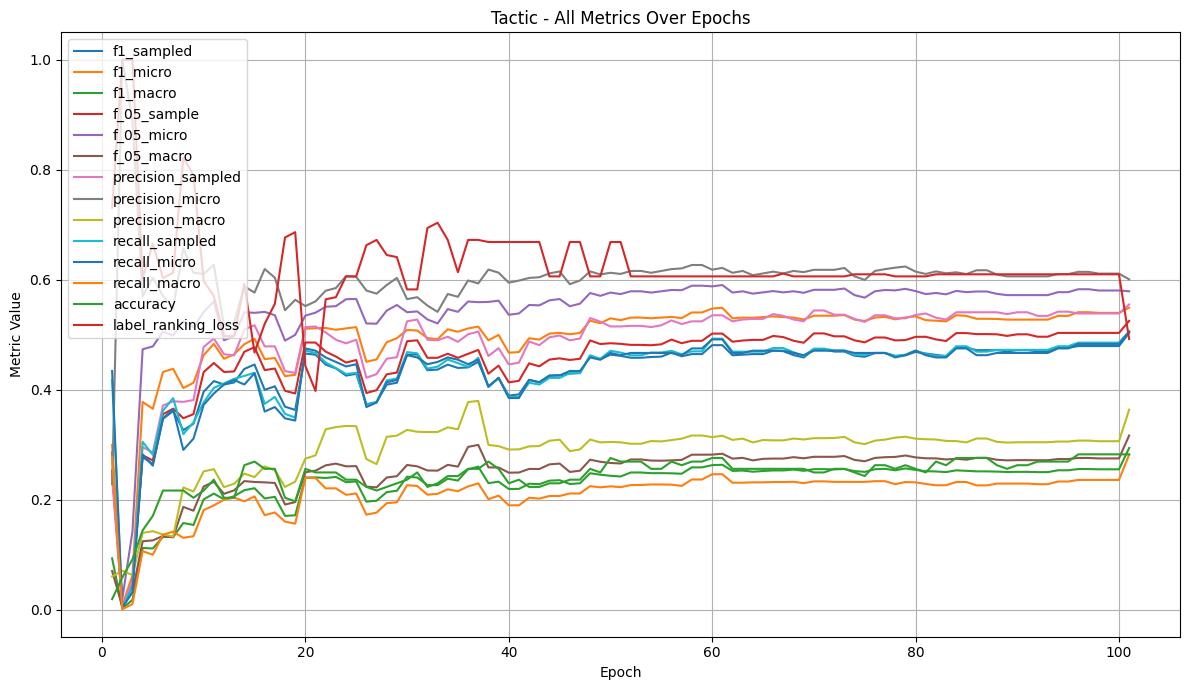

In [82]:
plt.figure(figsize=(12, 7))
epochs = range(1, len(metrics_log) + 1)
for metric_name, values in metrics_data.items():
    print(f"{metric_name}: {len(values)}")
    if metric_name != 'lrap' and metric_name != 'coverage_error':
        plt.plot(epochs, values, label=metric_name)

plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Tactic - All Metrics Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

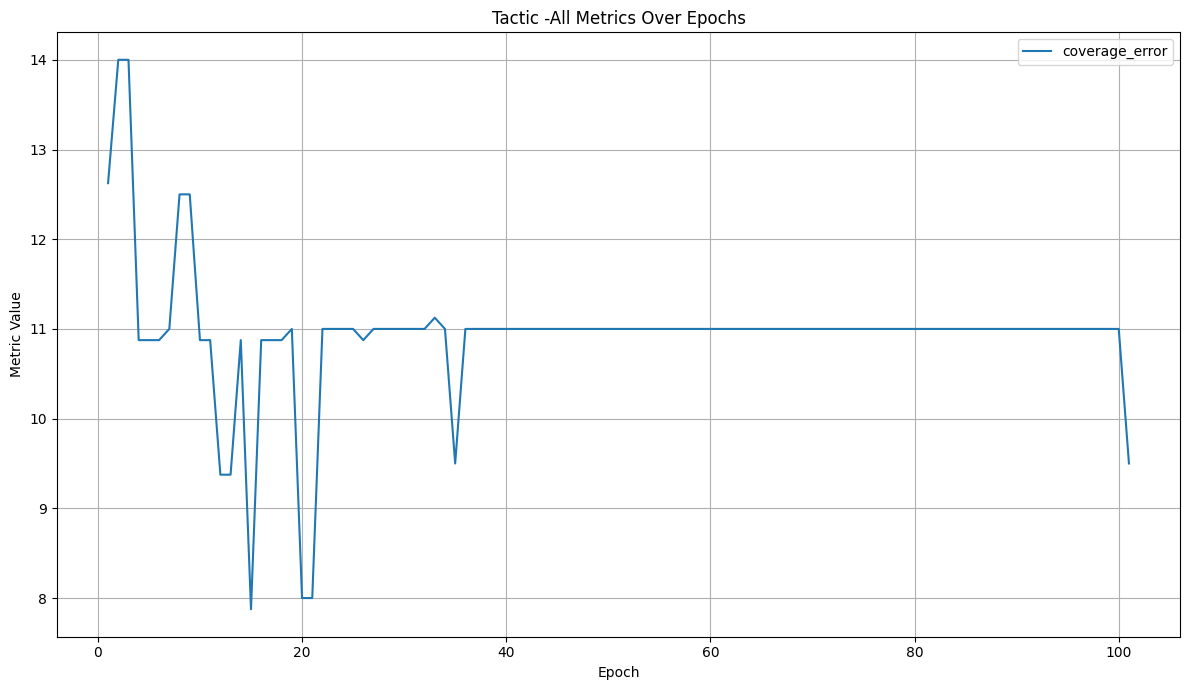

In [83]:
plt.figure(figsize=(12, 7))
epochs = range(1, len(metrics_log) + 1)
for metric_name, values in metrics_data.items():
    # print(f"{metric_name}: {len(values)}")
    if metric_name == 'coverage_error':
        plt.plot(epochs, values, label=metric_name)

plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Tactic -All Metrics Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

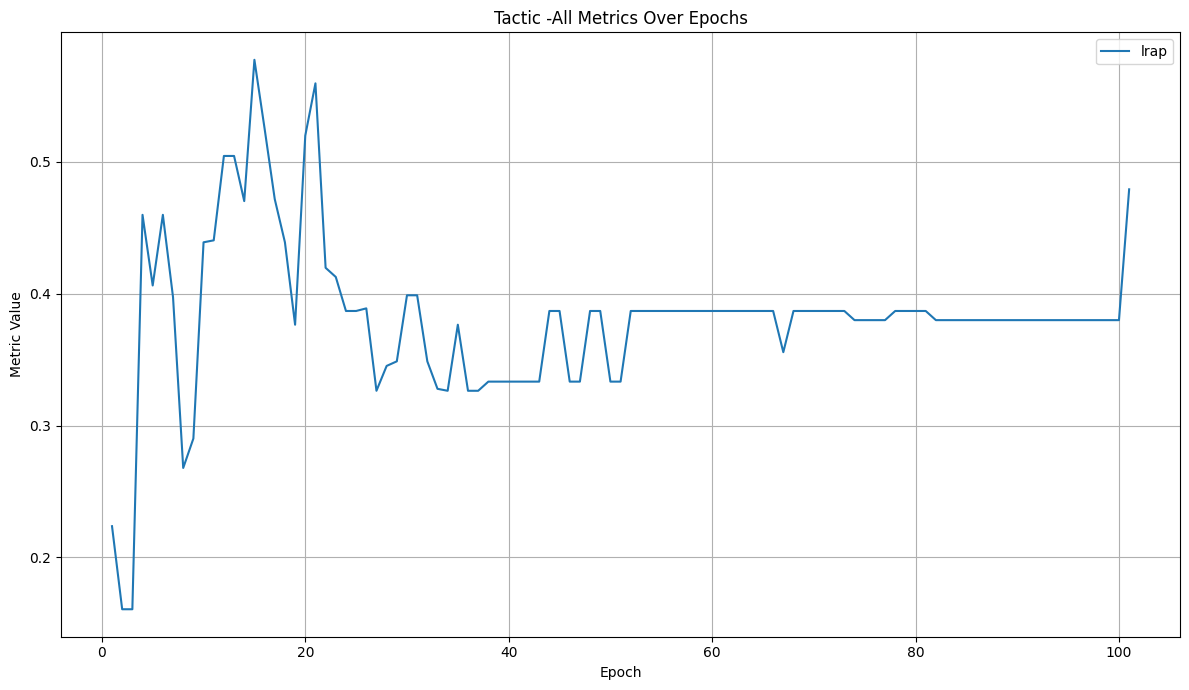

In [84]:
plt.figure(figsize=(12, 7))
epochs = range(1, len(metrics_log) + 1)
for metric_name, values in metrics_data.items():
    # print(f"{metric_name}: {len(values)}")
    if metric_name == 'lrap':
        plt.plot(epochs, values, label=metric_name)

plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Tactic -All Metrics Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [85]:
def print_F1_based_on_distribution(y_true, y_pred, Y, columns):
  fig,ax = plt.subplots()

  results = pd.DataFrame(columns = columns)
  results.loc[len(results)] = f1_score(y_true, y_pred, average=None)


  Y_count = Y.apply(np.sum, axis=0)

  # print(Y_count[0:14])

  Y_count_sorted = Y_count[0:14].sort_values(ascending=False)

  ax.bar(Y_count_sorted.index, Y_count_sorted.values)
  ax.set_xlabel("Tactics")
  ax.set_ylabel("Number of CVEs")
  plt.xticks(rotation=90)

  ax2=ax.twinx()
  ax2.plot(Y_count_sorted.index, results[Y_count_sorted.index].iloc[0], color='red')
  ax2.set_ylabel("F1 Score")

  ax = plt.gca()
  plt.show()

In [86]:
def print_precision_based_on_distribution(y_true, y_pred, Y, columns):
  fig,ax = plt.subplots()

  results = pd.DataFrame(columns = columns)
  results.loc[len(results)] = precision_score(y_true, y_pred, average=None)


  Y_count = Y.apply(np.sum, axis=0)

  # print(Y_count[0:14])

  Y_count_sorted = Y_count[0:14].sort_values(ascending=False)

  ax.bar(Y_count_sorted.index, Y_count_sorted.values)
  ax.set_xlabel("Tactics")
  ax.set_ylabel("Number of CVEs")
  plt.xticks(rotation=90)

  ax2=ax.twinx()
  ax2.plot(Y_count_sorted.index, results[Y_count_sorted.index].iloc[0], color='red')
  ax2.set_ylabel("Precision Score")

  ax = plt.gca()
  plt.show()

In [87]:
def compute_metrics(predicted_y, true_y, metric_function, columns, limit):
  results = pd.DataFrame(columns = columns)
  if (metric_function == accuracy_score):
    results.loc[len(results)] = metric_function(true_y, predicted_y)
  else:
    results.loc[len(results)] = metric_function(true_y, predicted_y, average=None)

  sorted_results = results.sort_values(by=0, axis=1, ascending=False)

  for col in sorted_results.columns[:limit]:
        print(f"{col}: {sorted_results[col].values[0]}")

  return sorted_results.iloc[:, :limit]

In [88]:
df = pd.read_csv('merged_all_columns.csv', encoding='utf-8')
# df_attack['tactic_label'] = df_attack.apply(lambda x: list(x[TACTIC]), axis=1)
# df_attack['technique_label'] = df_attack.apply(lambda x: list(x[TECHNIQUE]), axis=1)

df_tactic_labels = df[TACTIC]
df_technique_labels = df[TECHNIQUE]

df['tactic_label'] = df.apply(lambda x: list(x[TACTIC]), axis=1)
df['technique_label'] = df.apply(lambda x: list(x[TECHNIQUE]), axis=1)

df['text_clean'] = df['Text'].map(lambda t: preprocess(t))


train, test = train_test_split(df, test_size=0.2, random_state=2222)
validation, test = train_test_split(test, test_size=0.5, random_state=2222)


In [89]:
print("------Validation results --------")
print(BEST_F1)

print("F1 scores per class")
y_train_df = train.drop(train.columns[0:2], axis=1)

f1_best_metrics = compute_metrics(BEST_PREDICTED, BEST_TRUE, f1_score, test.columns[2:16], 14)
print("----------------------------------")

print("Recall scores per class")
recall_best_metrics = compute_metrics(BEST_PREDICTED, BEST_TRUE, recall_score, test.columns[2:16], 14)
print("----------------------------------")

print("Precision scores per class")
precision_best_metrics = compute_metrics(BEST_PREDICTED, BEST_TRUE, precision_score, test.columns[2:16], 14)
print("----------------------------------")

print("Accuracy scores per class")
acc_best_metrics = compute_metrics(BEST_PREDICTED, BEST_TRUE, accuracy_score, test.columns[2:16], 14)

------Validation results --------
0.5163175163455695
F1 scores per class
TA0040: 0.7619047619047619
TA0002: 0.6851851851851852
TA0006: 0.6
TA0009: 0.5806451612903226
TA0001: 0.5121951219512195
TA0004: 0.4444444444444444
TA0005: 0.1111111111111111
TA0003: 0.0
TA0008: 0.0
TA0007: 0.0
TA0010: 0.0
TA0011: 0.0
TA0042: 0.0
TA0043: 0.0
----------------------------------
Recall scores per class
TA0040: 0.75
TA0002: 0.6981132075471698
TA0009: 0.6428571428571429
TA0006: 0.5
TA0001: 0.45652173913043476
TA0004: 0.3448275862068966
TA0005: 0.0625
TA0003: 0.0
TA0008: 0.0
TA0007: 0.0
TA0010: 0.0
TA0011: 0.0
TA0042: 0.0
TA0043: 0.0
----------------------------------
Precision scores per class
TA0040: 0.7741935483870968
TA0006: 0.75
TA0002: 0.6727272727272727
TA0004: 0.625
TA0001: 0.5833333333333334
TA0009: 0.5294117647058824
TA0005: 0.5
TA0003: 0.0
TA0008: 0.0
TA0007: 0.0
TA0010: 0.0
TA0011: 0.0
TA0042: 0.0
TA0043: 0.0
----------------------------------
Accuracy scores per class
TA0001: 0.2763157894736

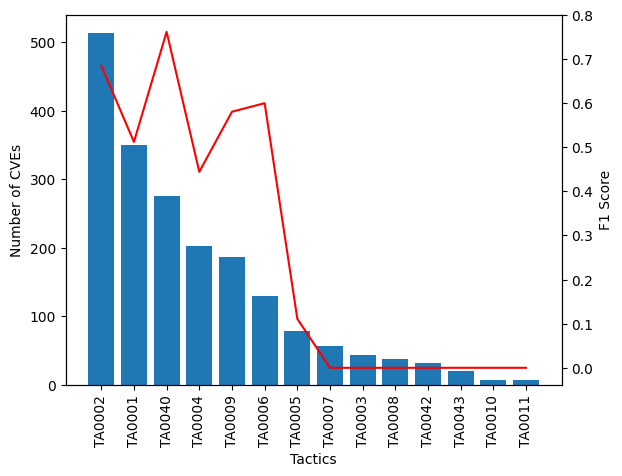

In [90]:
print_F1_based_on_distribution(BEST_PREDICTED, BEST_TRUE, y_train_df,  test.columns[2:16])

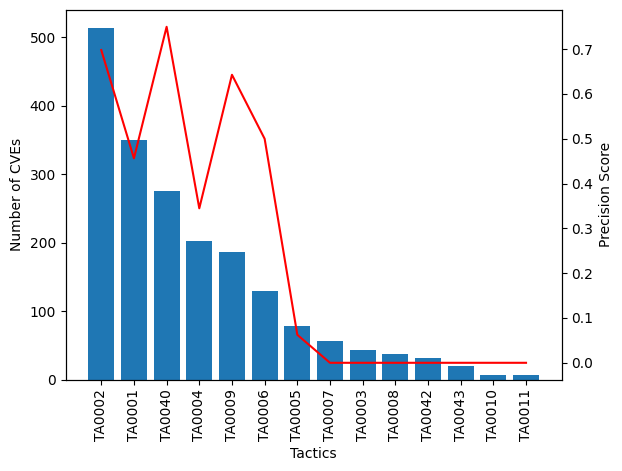

In [91]:
print_precision_based_on_distribution(BEST_PREDICTED, BEST_TRUE, y_train_df,  test.columns[2:16])